In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
from numba import njit

import mplhep as hep
plt.style.use(hep.style.CMS)

In [6]:
inputfile = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/gammas/gamma_126X_mcRun3_2023_forPU65_v4.hdf5"
outputdir = "/eos/user/j/jabrunne/www/ECAL/Clustering/DeepCluster/validation_sim_truth/V2/simfraction_photon"
os.makedirs(outputdir, exist_ok=True)

In [7]:
store_ele = pd.HDFStore(inputfile, "r")
df =store_ele['df']
store_ele.close()
df.rename(columns={"output.csv":"window_index"}, inplace=True)
df = df.iloc[:-1]

In [8]:
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst)

# Having a look at the dataset
It contains all the cluster around each caloparticle. 
Both the clusters inside and output the "dynamic window" limits are included, so that all the truth level info can be analyzed.

In [5]:
df

window_index           en          et  ieta   iphi       eta       phi  \
0          nnetyuks  1711.452881  353.724001  62.0   31.0  2.258874 -1.029576   
1          vefwmrxy  1040.959717  261.848837  60.0   24.0 -2.057070 -1.241010   
2          ghcqtoaa   481.389648  273.499820  67.0  227.0  1.165820 -2.504151   
3          ghcqtoaa     7.311409    4.134025  67.0  224.0  1.171656 -2.560788   
4          maalovbg   165.902786  100.370627 -63.0   26.0 -1.088221  0.261791   
...             ...          ...         ...   ...    ...       ...       ...   
205237     myghjgkq  2208.700928  267.845917  60.0   41.0  2.799198 -0.779776   
205238     jdbxdevc  1225.503906  281.906661  33.0   32.0 -2.149179 -2.331318   
205239     jdbxdevc     1.442210    0.375798  32.0   28.0 -2.020603 -2.259256   
205240     cfaajegt   356.159454  353.366930   8.0  148.0  0.125636  2.400653   
205241     mucxwyru   234.682846  188.197436 -40.0  251.0 -0.689138 -2.081397   

         iz  simfrac_sig    simen_sig  ...  obsPU   calo_simen  calo_simet  \
0       1.0     0.962155  1619.924035  ...   39.0  1683.484863  347.930732   
1      -1.0     0.978793   982.227181  ...   39.0  1003.506958  252.473314   
2       0.0     0.968398   467.799789  ...   39.0   483.060913  274.505401   
3       0.0     0.012968     6.264542  ...   39.0   483.060913  274.505401   
4       0.0     0.879143   161.428165  ...   39.0   183.616562  111.064511   
...     ...          ...          ...  ...    ...          ...         ...   
205237  1.0     0.931161  2032.445479  ...   65.0  2182.697266  266.325558   
205238 -1.0     0.979902  1178.425154  ...   65.0  1202.535645  276.646882   
205239 -1.0     0.000126     0.150972  ...   65.0  1202.535645  276.646882   
205240  0.0     0.981730   345.076104  ...   65.0   351.497711  348.741439   
205241  0.0     0.979349   226.602147  ...   65.0   231.380417  185.549475   

        calo_simen_good  calo_geneta  calo_genphi  calo_simeta  calo_simphi  \
0           1658.682983     2.270517    -1.030000     2.258911    -1.029672   
1           1003.466919    -2.056560    -1.241776    -2.056884    -1.241125   
2            483.043671     1.175026    -2.506917     1.165572    -2.504101   
3            483.043671     1.175026    -2.506917     1.165572    -2.504101   
4            183.615921    -1.078901     0.257939    -1.088480     0.257088   
...                 ...          ...          ...          ...          ...   
205237      2182.520996     2.787455    -0.786754     2.793001    -0.786038   
205238      1199.786133    -2.158792    -2.332234    -2.149091    -2.330908   
205239      1199.786133    -2.158792    -2.332234    -2.149091    -2.330908   
205240       351.497284     0.106111     2.403427     0.125643     2.400608   
205241       231.352554    -0.703585    -2.082008    -0.689135    -2.081424   

         calo_genen  calo_genet  
0       1734.497925  354.425313  
1       1028.387207  258.814049  
2        496.341705  279.862672  
3        496.341705  279.862672  
4        190.723755  116.244841  
...             ...         ...  
205237  2237.351318  274.501150  
205238  1229.099243  280.100514  
205239  1229.099243  280.100514  
205240   405.070160  402.800369  
205241   236.810989  188.259493  

[5884624 rows x 27 columns]

# Building the window

Collecting all the clusters around the same seed by the window_index columns. 
The `calo_match_dataset.py` script collects all the clusters with some caloparticle deposition around each seed. 
The seed in this case is the PFCluster with the highest score for each caloparticle. 

In [9]:
seed = df[(df.is_seed==1)][['window_index','en','eta','et', 'simfrac_sig']]
seed.columns = ['window_index','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("window_index"), on='window_index')

# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)

In [32]:
dfa

window_index           en          et  ieta   iphi       eta       phi  \
0          nnetyuks  1711.452881  353.724001  62.0   31.0  2.258874 -1.029576   
1          vefwmrxy  1040.959717  261.848837  60.0   24.0 -2.057070 -1.241010   
2          ghcqtoaa   481.389648  273.499820  67.0  227.0  1.165820 -2.504151   
3          ghcqtoaa     7.311409    4.134025  67.0  224.0  1.171656 -2.560788   
4          maalovbg   165.902786  100.370627 -63.0   26.0 -1.088221  0.261791   
...             ...          ...         ...   ...    ...       ...       ...   
205237     myghjgkq  2208.700928  267.845917  60.0   41.0  2.799198 -0.779776   
205238     jdbxdevc  1225.503906  281.906661  33.0   32.0 -2.149179 -2.331318   
205239     jdbxdevc     1.442210    0.375798  32.0   28.0 -2.020603 -2.259256   
205240     cfaajegt   356.159454  353.366930   8.0  148.0  0.125636  2.400653   
205241     mucxwyru   234.682846  188.197436 -40.0  251.0 -0.689138 -2.081397   

         iz  simfrac_sig    simen_sig  ...  calo_geneta  calo_genphi  \
0       1.0     0.962155  1619.924035  ...     2.270517    -1.030000   
1      -1.0     0.978793   982.227181  ...    -2.056560    -1.241776   
2       0.0     0.968398   467.799789  ...     1.175026    -2.506917   
3       0.0     0.012968     6.264542  ...     1.175026    -2.506917   
4       0.0     0.879143   161.428165  ...    -1.078901     0.257939   
...     ...          ...          ...  ...          ...          ...   
205237  1.0     0.931161  2032.445479  ...     2.787455    -0.786754   
205238 -1.0     0.979902  1178.425154  ...    -2.158792    -2.332234   
205239 -1.0     0.000126     0.150972  ...    -2.158792    -2.332234   
205240  0.0     0.981730   345.076104  ...     0.106111     2.403427   
205241  0.0     0.979349   226.602147  ...    -0.703585    -2.082008   

        calo_simeta  calo_simphi   calo_genen  calo_genet      seed_en  \
0          2.258911    -1.029672  1734.497925  354.425313  1711.452881   
1         -2.056884    -1.241125  1028.387207  258.814049  1040.959717   
2          1.165572    -2.504101   496.341705  279.862672   481.389648   
3          1.165572    -2.504101   496.341705  279.862672   481.389648   
4         -1.088480     0.257088   190.723755  116.244841   165.902786   
...             ...          ...          ...         ...          ...   
205237     2.793001    -0.786038  2237.351318  274.501150  2208.700928   
205238    -2.149091    -2.330908  1229.099243  280.100514  1225.503906   
205239    -2.149091    -2.330908  1229.099243  280.100514  1225.503906   
205240     0.125643     2.400608   405.070160  402.800369   356.159454   
205241    -0.689135    -2.081424   236.810989  188.259493   234.682846   

        seed_eta     seed_et  seed_simfrac_sig  
0       2.258874  353.724001          0.962155  
1      -2.057070  261.848837          0.978793  
2       1.165820  273.499820          0.968398  
3       1.165820  273.499820          0.968398  
4      -1.088221  100.370627          0.879143  
...          ...         ...               ...  
205237  2.799198  267.845917          0.931161  
205238 -2.149179  281.906661          0.979902  
205239 -2.149179  281.906661          0.979902  
205240  0.125636  353.366930          0.981730  
205241 -0.689138  188.197436          0.979349  

[5884737 rows x 31 columns]

(array([3134., 7576., 7903., 7486., 6795., 6412., 5940., 5691., 5667.,
        5531., 5497., 5542., 5425., 5207., 5098., 5161., 4911., 5005.,
        4970., 4782., 4702., 4593., 4589., 4389., 4488., 4405., 4351.,
        4426., 4361., 4214., 4305., 4277., 4215., 4109., 4117., 4047.,
        3993., 4090., 3963., 3990., 3943., 3941., 3889., 3960., 3861.,
        3717., 4005., 3846., 3838., 3865.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

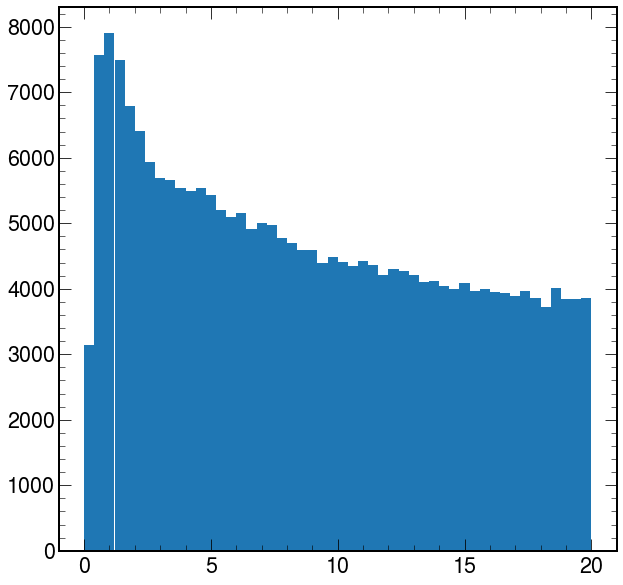

In [33]:
plt.hist(dfb[dfb.is_seed==1].seed_et, bins=50, range=(0,20))

(array([[106.,  26.,  43., ...,  64.,   9.,   0.],
        [675., 226., 321., ..., 255., 167., 613.],
        [381., 203., 291., ..., 270., 207., 233.],
        ...,
        [226., 262., 239., ..., 211., 217., 223.],
        [194., 243., 205., ..., 236., 235., 215.],
        [220., 235., 257., ..., 230., 267., 197.]]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
        26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
        35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <matplotlib.collections.QuadMesh at 0x7fd5980a6b20>)

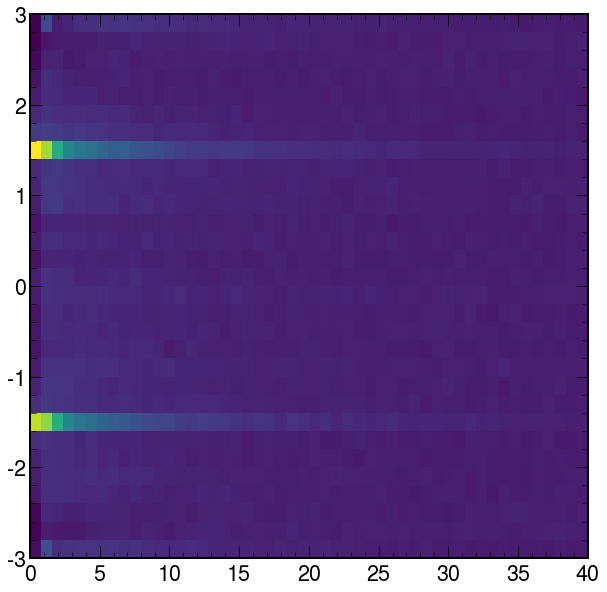

In [34]:
plt.hist2d(dfb[dfb.is_seed==1].seed_et, dfb[dfb.is_seed==1].seed_eta, bins=(50, 30), range=((0,40), (-3,3)))

# Window dimension study

In [10]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,4,10,15,25,40,50,70,100, 150, 200, 300, 500]

In [11]:
H, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

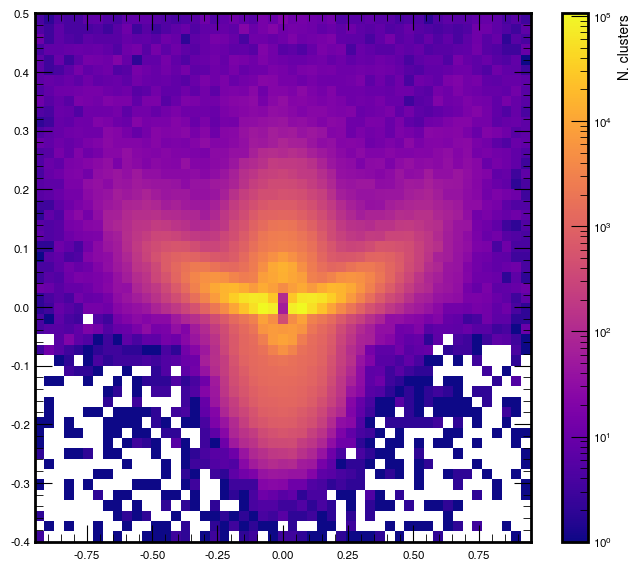

In [13]:
plt.figure(figsize=(8,7), dpi=100)
I = plt.pcolormesh(X, Y, H.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(I, label="N. clusters")

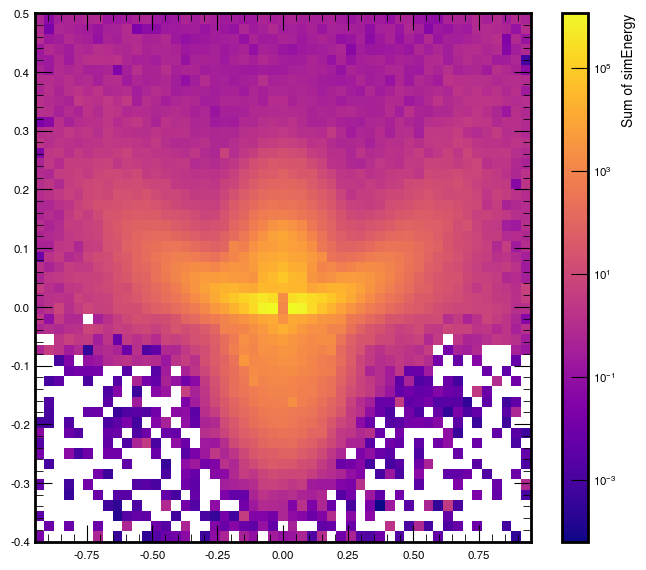

In [22]:
plt.figure(figsize=(8,7), dpi=100)

I = plt.pcolormesh(X, Y, Hfrac.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(label="Sum of simEnergy")

Plotting the normalized distribution of the profiled simEnergy in each bin

/tmp/ipykernel_1189/4061902690.py:2: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)


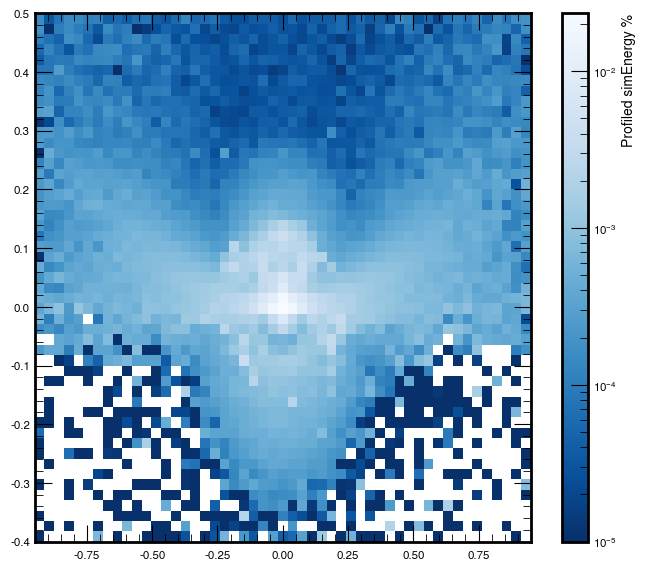

In [25]:
plt.figure(figsize=(8,7), dpi=100)
profile_simen = (Hfrac/H)
np.nan_to_num(profile_simen, copy=False, nan=0.)
prof_simen_perc = profile_simen / np.sum(profile_simen)

I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy %")

#$plt.gca().set_xticklabels(phibins)

Plotting the normalized distribution of the profiled simEnergy/caloEn in each bin

/tmp/ipykernel_1189/2531401568.py:10: RuntimeWarning: invalid value encountered in divide
  profile_simen2 = (Hfrac2/H2)


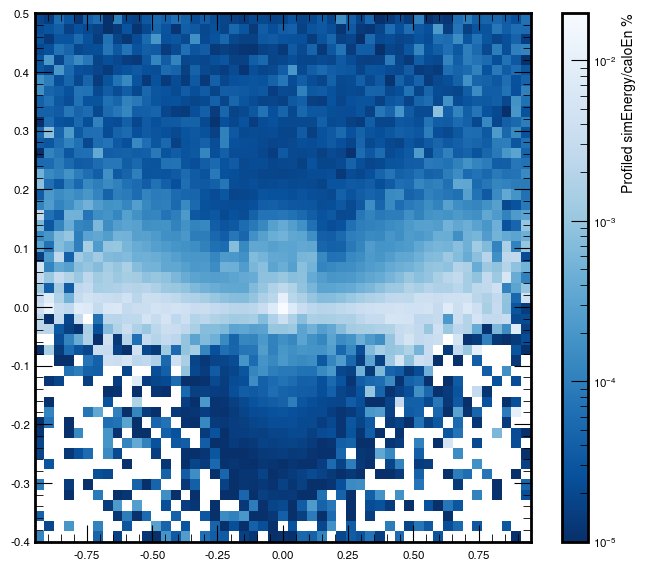

In [28]:
H2, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac2, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig/dfb[dfb.is_seed==0].calo_simen_good, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

plt.figure(figsize=(8,7), dpi=100)
profile_simen2 = (Hfrac2/H2)
np.nan_to_num(profile_simen2, copy=False, nan=0.)
prof_simen_perc2 = profile_simen2 / np.sum(profile_simen2)

I = plt.pcolormesh(X, Y, prof_simen_perc2.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy/caloEn %")

#$plt.gca().set_xticklabels(phibins)

### Studying the profile

In [29]:
import numba 
@numba.njit
def get_binrange(X, perc, direction=1):
    S = 0.
    i = 0 if direction>0 else len(X)-1
    while(S<perc):
        S += X[i]
        i += direction
    return i

Text(1, 0, 'ieta, (iphi profiled)')

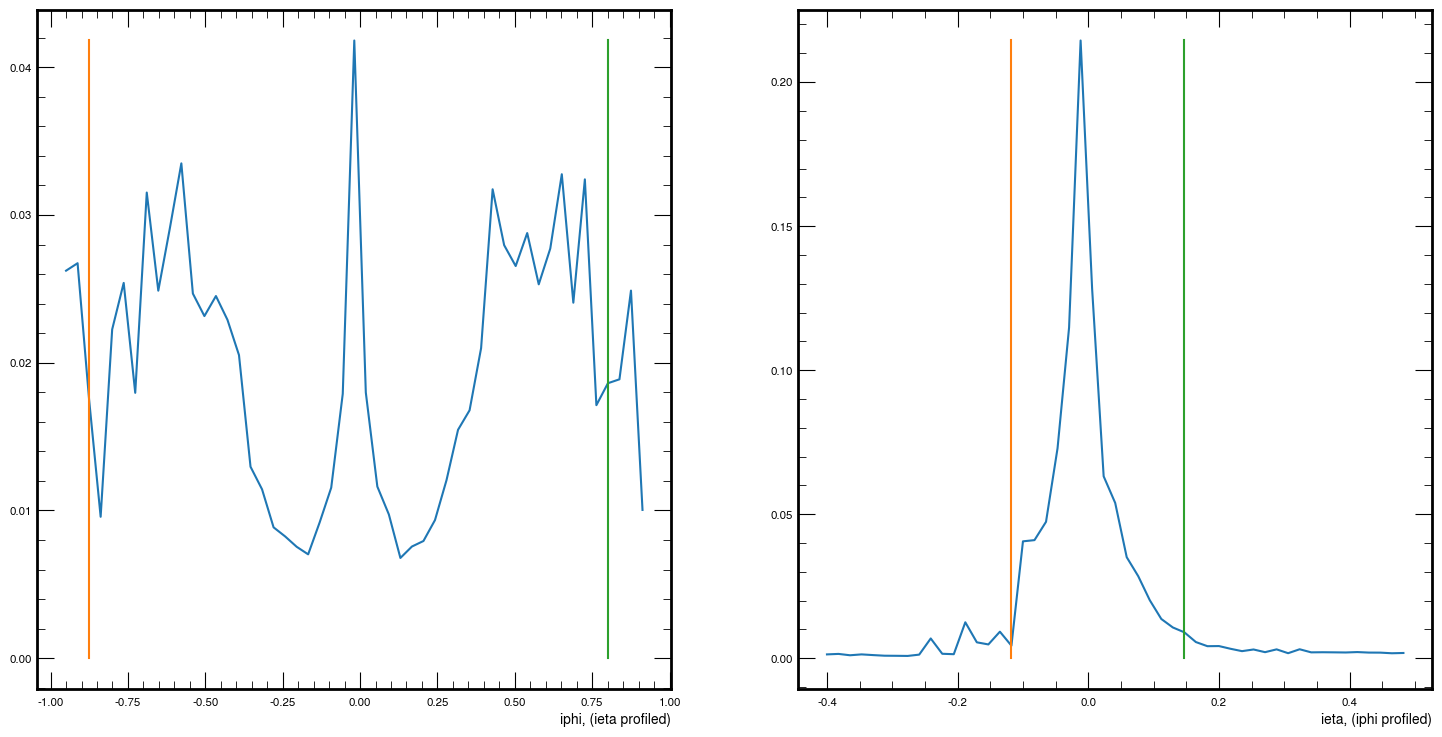

In [32]:
iphi_profile = np.sum(prof_simen_perc2, axis=1)
ieta_profile = np.sum(prof_simen_perc2.T, axis=1)

prob = 0.05
iphi_min =  get_binrange(iphi_profile,  prob)
iphi_max =  get_binrange(iphi_profile, prob, direction=-1)
ieta_min =  get_binrange(ieta_profile,  prob)
ieta_max =  get_binrange(ieta_profile, prob, direction=-1)

f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
a1.plot(phibins[:-1], iphi_profile)
a2.plot(etabins[:-1], ieta_profile)
a1.plot([phibins[iphi_min], phibins[iphi_min]], [0,np.max(iphi_profile)])
a1.plot([phibins[iphi_max], phibins[iphi_max]], [0,np.max(iphi_profile)])
a2.plot([etabins[ieta_min], etabins[ieta_min]], [0,np.max(ieta_profile)])
a2.plot([etabins[ieta_max], etabins[ieta_max]], [0,np.max(ieta_profile)])

a1.set_xlabel("iphi, (ieta profiled)")
a2.set_xlabel("ieta, (iphi profiled)")

## Now we do the same in bins of eta

In [33]:
eta_bins_wind = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0, 2.4, 3.0]

dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))

/tmp/ipykernel_1189/1576785483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))


### Plotting simEn profiles

/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/4240029626.py:16: RuntimeWarning: in

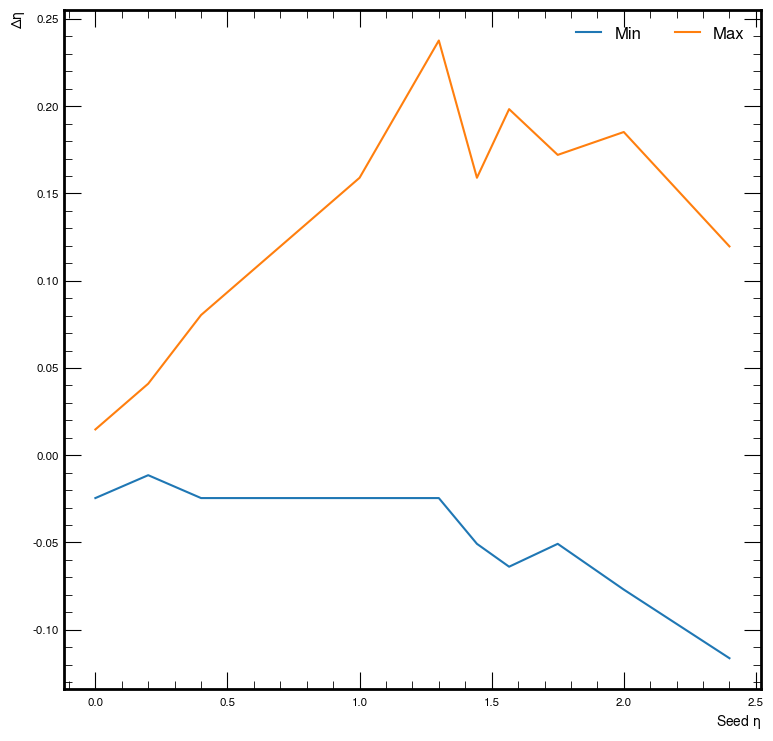

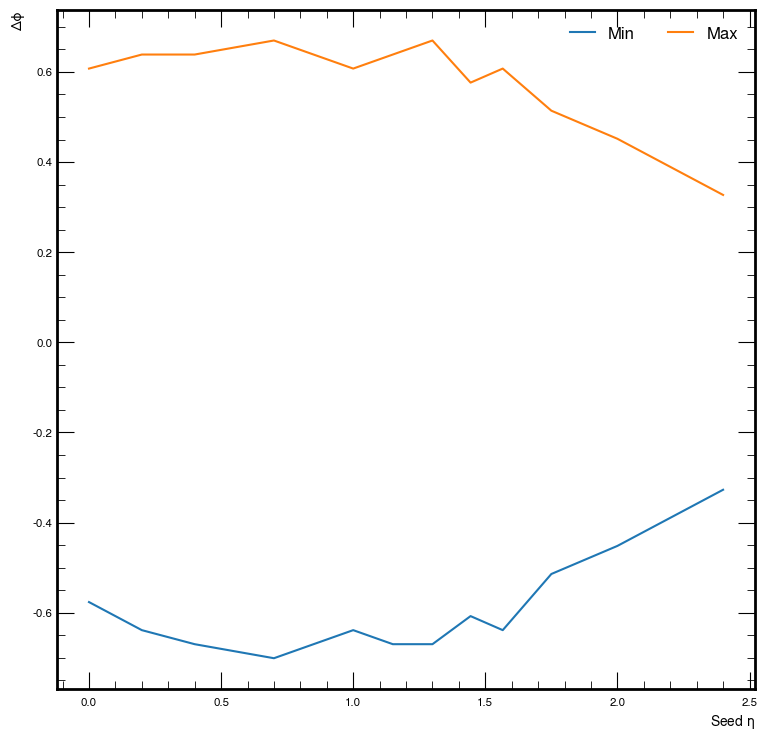

In [35]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig,  # --> simEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Plotting by simEn/CaloEn profiled

/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/3877013058.py:16: RuntimeWarning: in

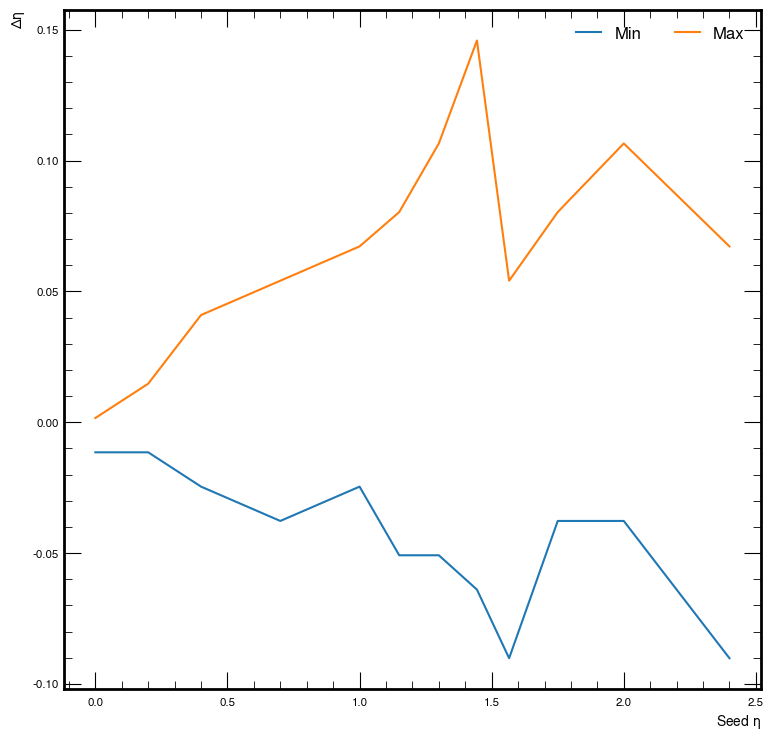

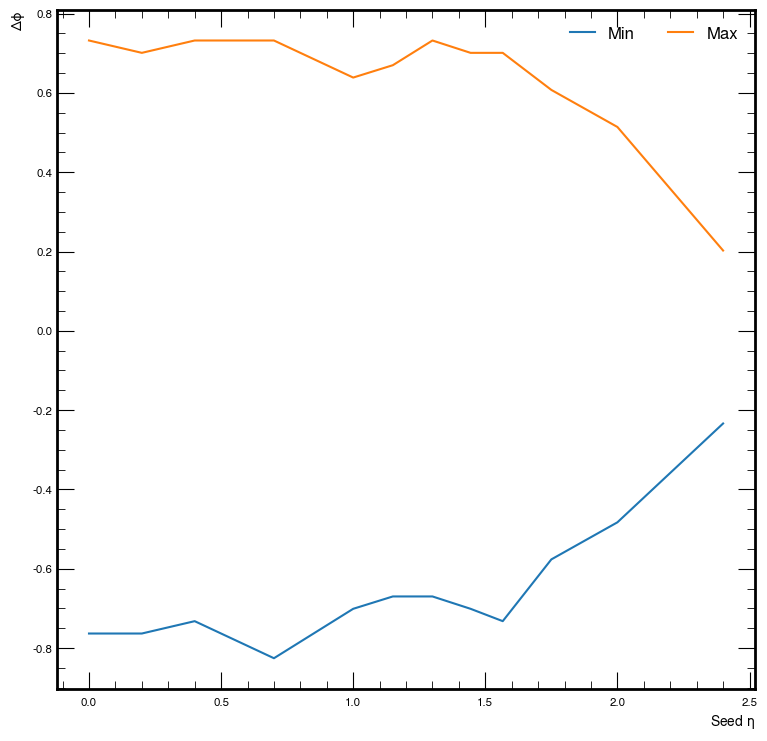

In [36]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig/df.calo_simen_good,  # ===> simEn/CaloEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy/CaloEn %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Approximate the trend as a linear function

In [14]:
def deta_window(seed_eta):
    EB_max = (0.1/1.5)*seed_eta + 0.1
    EB_min = np.ones_like(seed_eta) * (-0.1)
    EE_max = (0.1/1.5)*(seed_eta-1.5) + 0.2 
    EE_min = -0.1 + (-0.2/1.5)*(seed_eta-1.5)
    out_max = np.where(seed_eta<= 1.5, EB_max, EE_max)
    out_min = np.where(seed_eta<= 1.5, EB_min, EE_min)
    return out_max, out_min

@njit
def dphi_window(seed_eta):
    return 0.7 + (-0.1/3)*seed_eta,  -0.7 + (0.1/3)*seed_eta



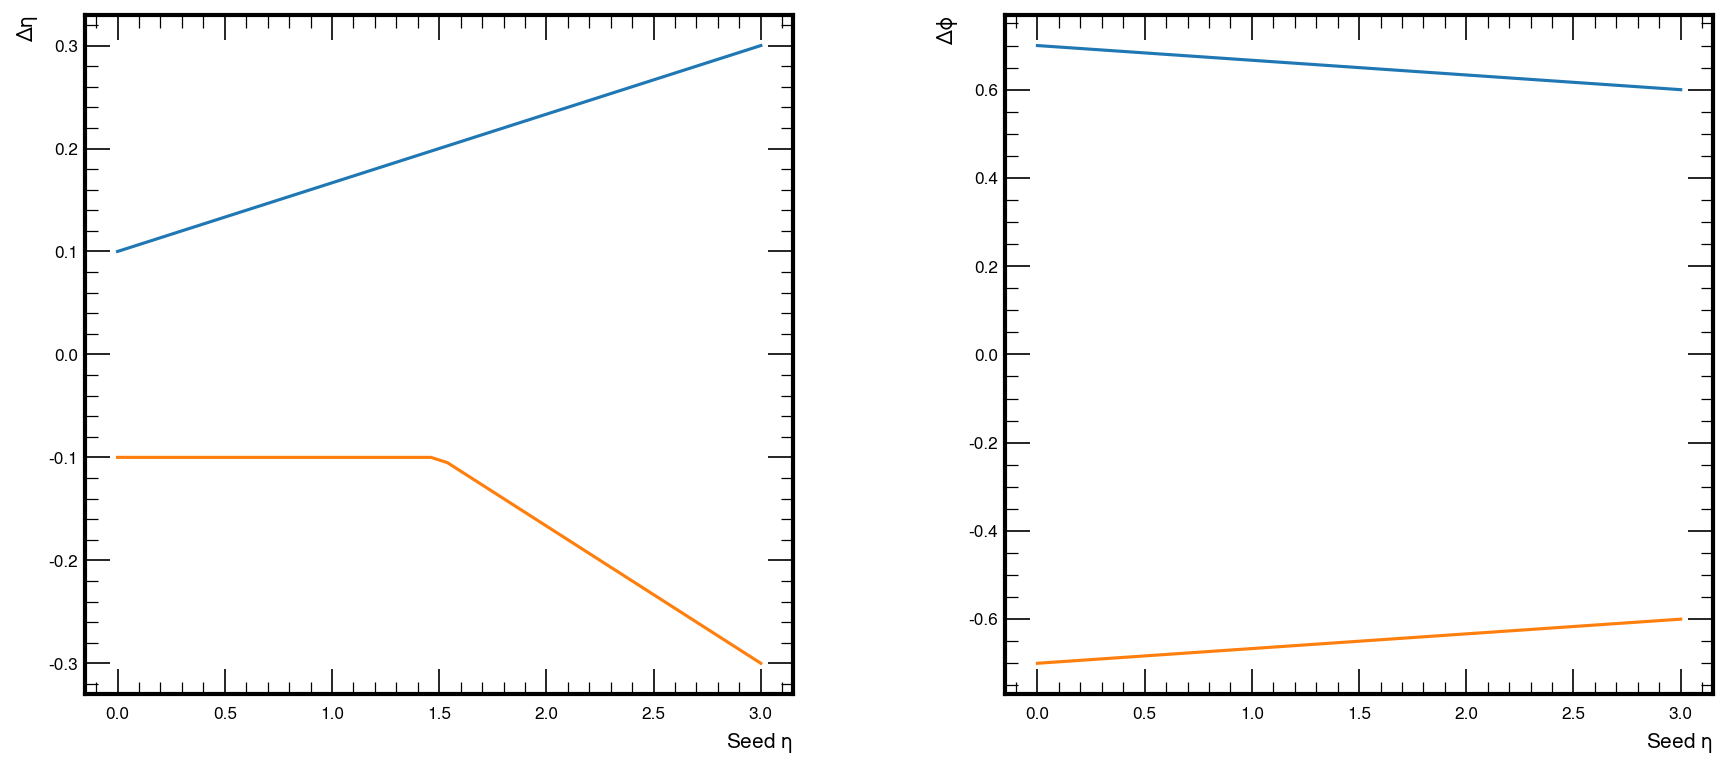

In [15]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)
seta = np.linspace(0, 3, 40)
emax, emin = deta_window(seta)
pmax, pmin = dphi_window(seta)
ax.plot(seta, emax)
ax.plot(seta, emin)
ax.set_ylabel("$\Delta\eta$")
ax.set_xlabel("Seed $\eta$")

ay.plot(seta, pmax)
ay.plot(seta, pmin)
ay.set_ylabel("$\Delta\phi$")
ay.set_xlabel("Seed $\eta$")

outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")


outputdirwind = outputdir + "/windows_simEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")

### Plots of the window with the final cut
Doing it both for simEn profile and also for simEn/CaloEn profile

In [41]:
outputdirwind = outputdir + "/windows_simeEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/656902725.py:14: RuntimeWarning: invalid val

Empty DataFrame
Columns: []
Index: []

In [42]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig/df.calo_simen_good, # --> simEn/CaloEN 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy/caloEn %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1189/199248077.py:14: RuntimeWarning: invalid val

Empty DataFrame
Columns: []
Index: []

# Resolution study

Let's study the best threshold for resolution. 
We have to apply the window definition before studying the best threshold.

Get the "seed", in this case the clusters with the highest score for the caloparticle, 
and collect the clusters around them and **apply** the geometrical window we have defined as a function of the seed eta

In [16]:
eta_max, eta_min = deta_window(dfb.seed_eta.abs().values)
phi_max, phi_min = dphi_window(dfb.seed_eta.abs().values)

dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \
                        (dfb.dphi_seed >= phi_min) & (dfb.dphi_seed <= phi_max)    

/tmp/ipykernel_2201/3615905916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \


Analyzing the truth level resolution for clusters in the geometrical window

In [17]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [18]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,4,10,15,25,40,50,70,100, 150, 200, 300, 500]

In [19]:
thres = np.logspace(-4,-0.7, 60)
    
res= []
# res_all = []

#Taking all the cluster passing the simfraction threshold, or beeing the seed
for i, thr in enumerate(thres):
    print(f"{i}) SimFracr threshold: {thr}")
    
    # we select only the clusters **inside the window** and passing the threshold or being the seed.
    g = dfb[ (dfb.in_window_new) & ((dfb.simfrac_sig >  thr) | (dfb.is_seed==1))]\
            .groupby("window_index", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)
    #scanres = applyParallel(g.groupby(["et_bin","eta_bin"]), bin_analysis)
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

0) SimFracr threshold: 0.0001
1) SimFracr threshold: 0.00011374497075739473
2) SimFracr threshold: 0.0001293791837260057
3) SimFracr threshold: 0.0001471623146953012
4) SimFracr threshold: 0.00016738973181607556
5) SimFracr threshold: 0.0001903974015050766
6) SimFracr threshold: 0.00021656746866478862
7) SimFracr threshold: 0.00024633460390279384
8) SimFracr threshold: 0.000280193223174577
9) SimFracr threshold: 0.0003187056997641244
10) SimFracr threshold: 0.00036251170499885317
11) SimFracr threshold: 0.0004123388328430786
12) SimFracr threshold: 0.0004690146848387425
13) SimFracr threshold: 0.0005334806161177142
14) SimFracr threshold: 0.0006068073707994633
15) SimFracr threshold: 0.0006902128664695653
16) SimFracr threshold: 0.0007850824231295831
17) SimFracr threshold: 0.0008929917726101903
18) SimFracr threshold: 0.0010157332306214009
19) SimFracr threshold: 0.0011553454661434532
20) SimFracr threshold: 0.0013141473626117554
21) SimFracr threshold: 0.0014947765333118152
22) SimFr

In [20]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0          0      0       0.551687     0.863861         0.734089   
1          1      0       0.617049     0.867774         0.754244   
2          2      0       0.608087     0.866983         0.755898   
3          3      0       0.574644     0.862622         0.736938   
4          4      0       0.571518     0.845837         0.723823   
...      ...    ...            ...          ...              ...   
8635       7     11       0.981397     1.031856         1.009490   
8636       8     11       1.001650     1.032449         1.017428   
8637       9     11       1.003661     1.029666         1.016843   
8638      10     11       0.999666     1.030985         1.015632   
8639      11     11       0.957713     1.047019         1.002693   

      EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0            0.156087       0.759723     0.858683  0.019440  0.000100  
1            0.125362       0.779962     0.847966  0.021096  0.000100  
2            0.129448       0.781880     0.994991  0.016688  0.000100  
3            0.143989       0.739782     0.363607  0.015352  0.000100  
4            0.137160       0.722045     0.166961  0.020847  0.000100  
...               ...            ...          ...       ...       ...  
8635         0.025230       1.011913     0.118161  0.005261  0.199526  
8636         0.015399       1.050393     0.883893  0.003344  0.199526  
8637         0.013002       1.016653     0.021414  0.002872  0.199526  
8638         0.015660       1.015396     0.016782  0.002276  0.199526  
8639         0.044653       1.002893     0.047319  0.002051  0.199526  

[8640 rows x 10 columns]

In [21]:
res.to_csv(outputdir + "/resolution_analysis_allthresholds.csv", sep=";", index=False)

## By Et and eta bin

Now plotting all the resolution

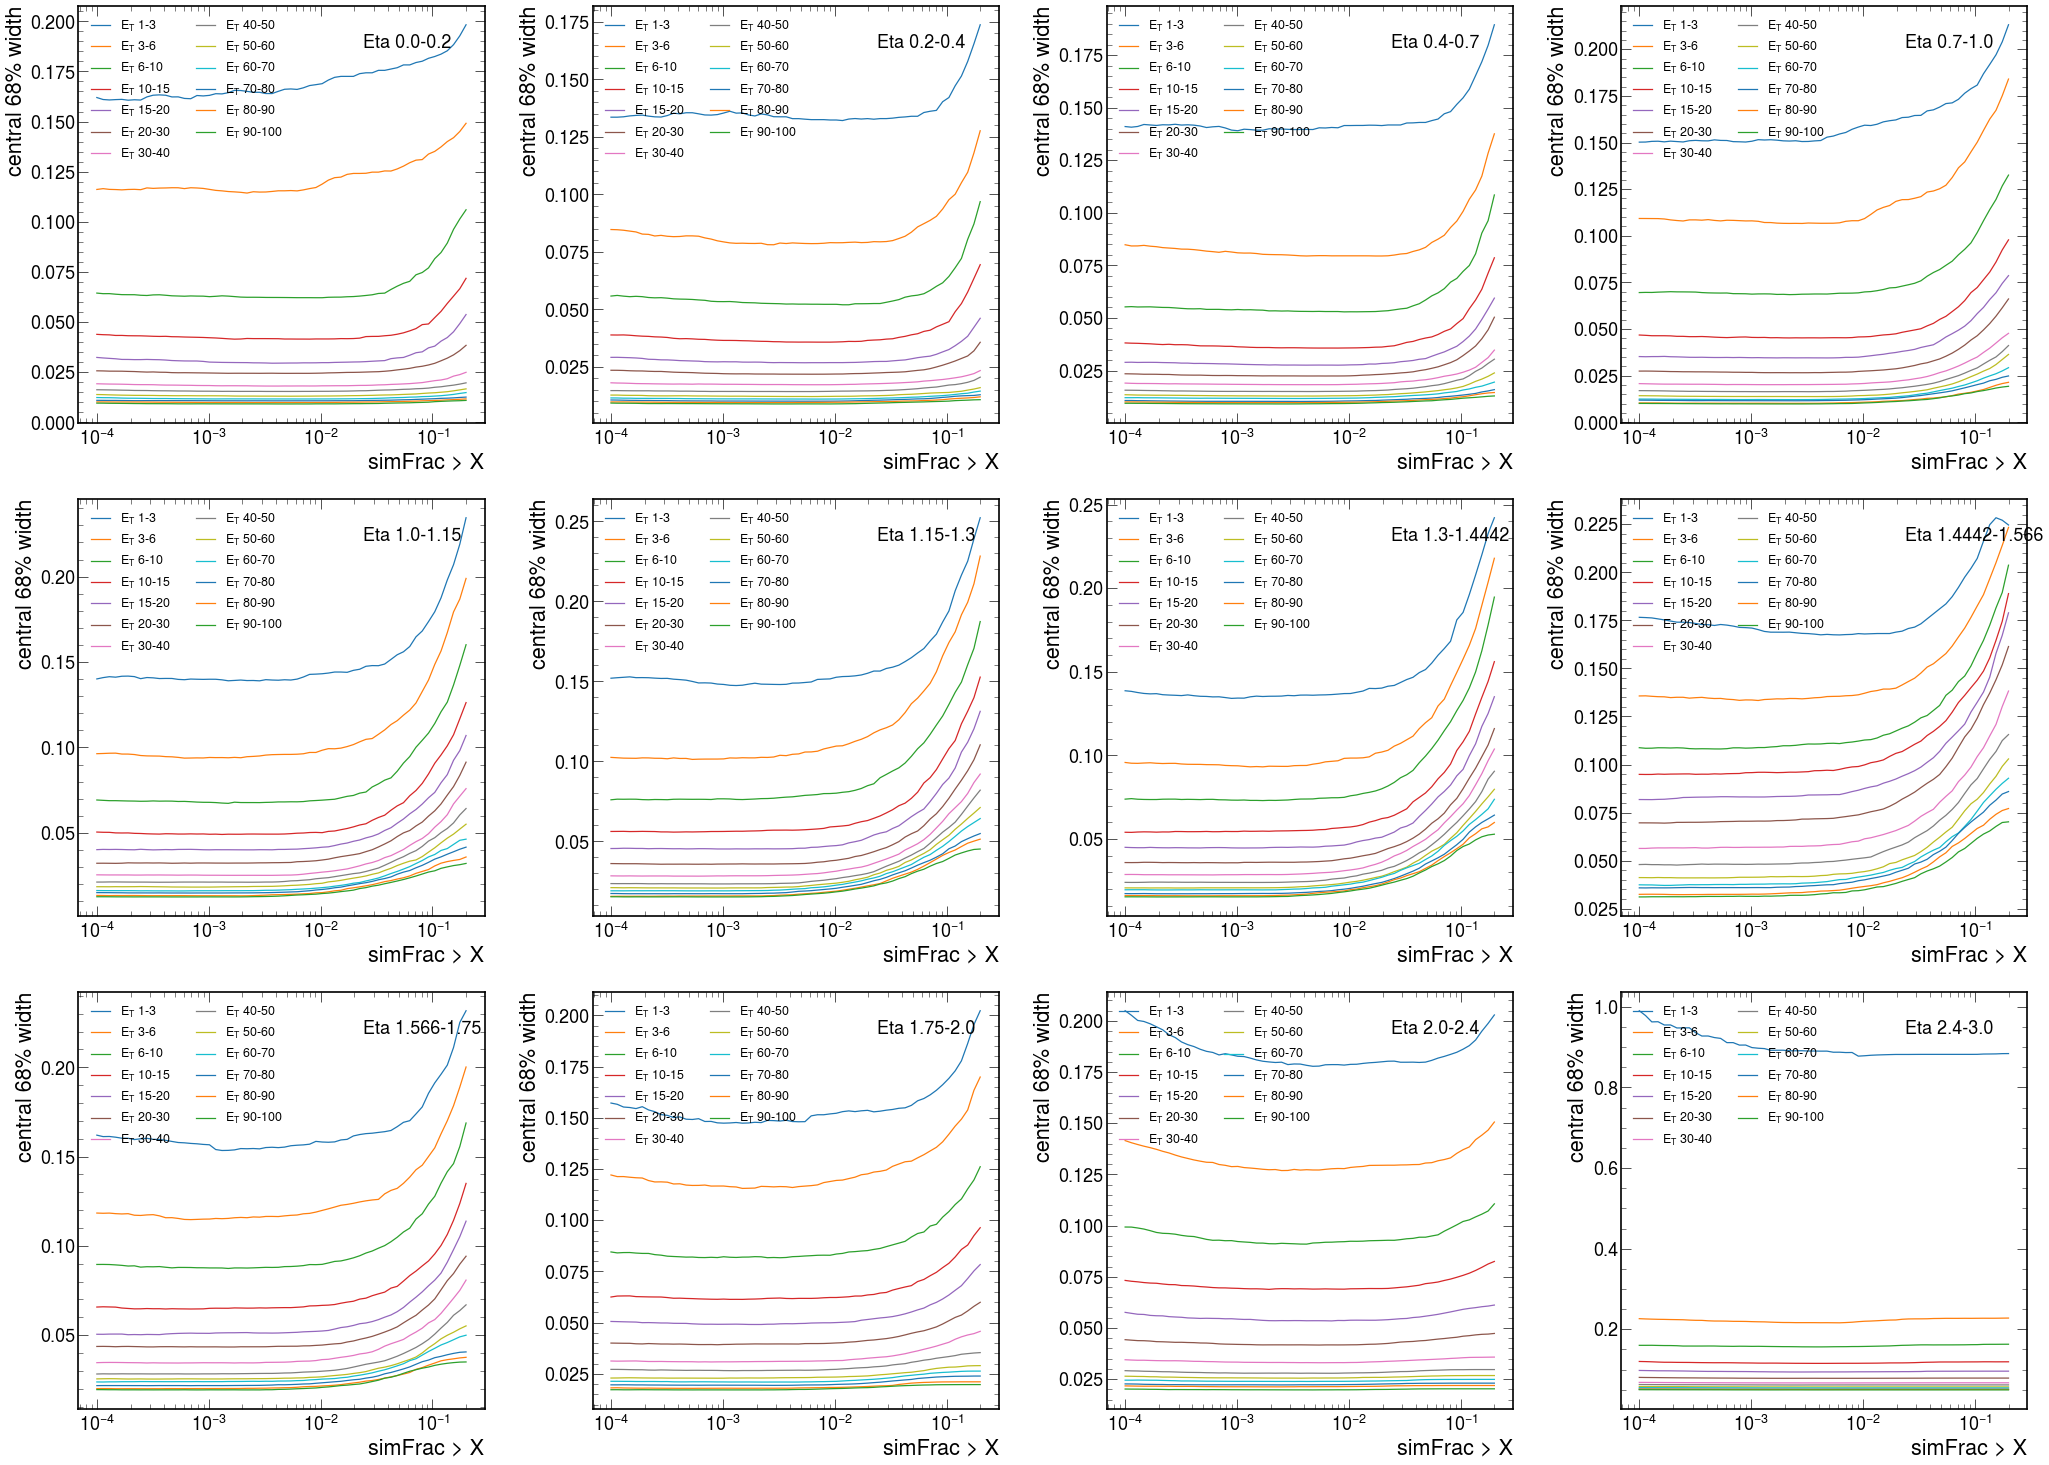

In [57]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

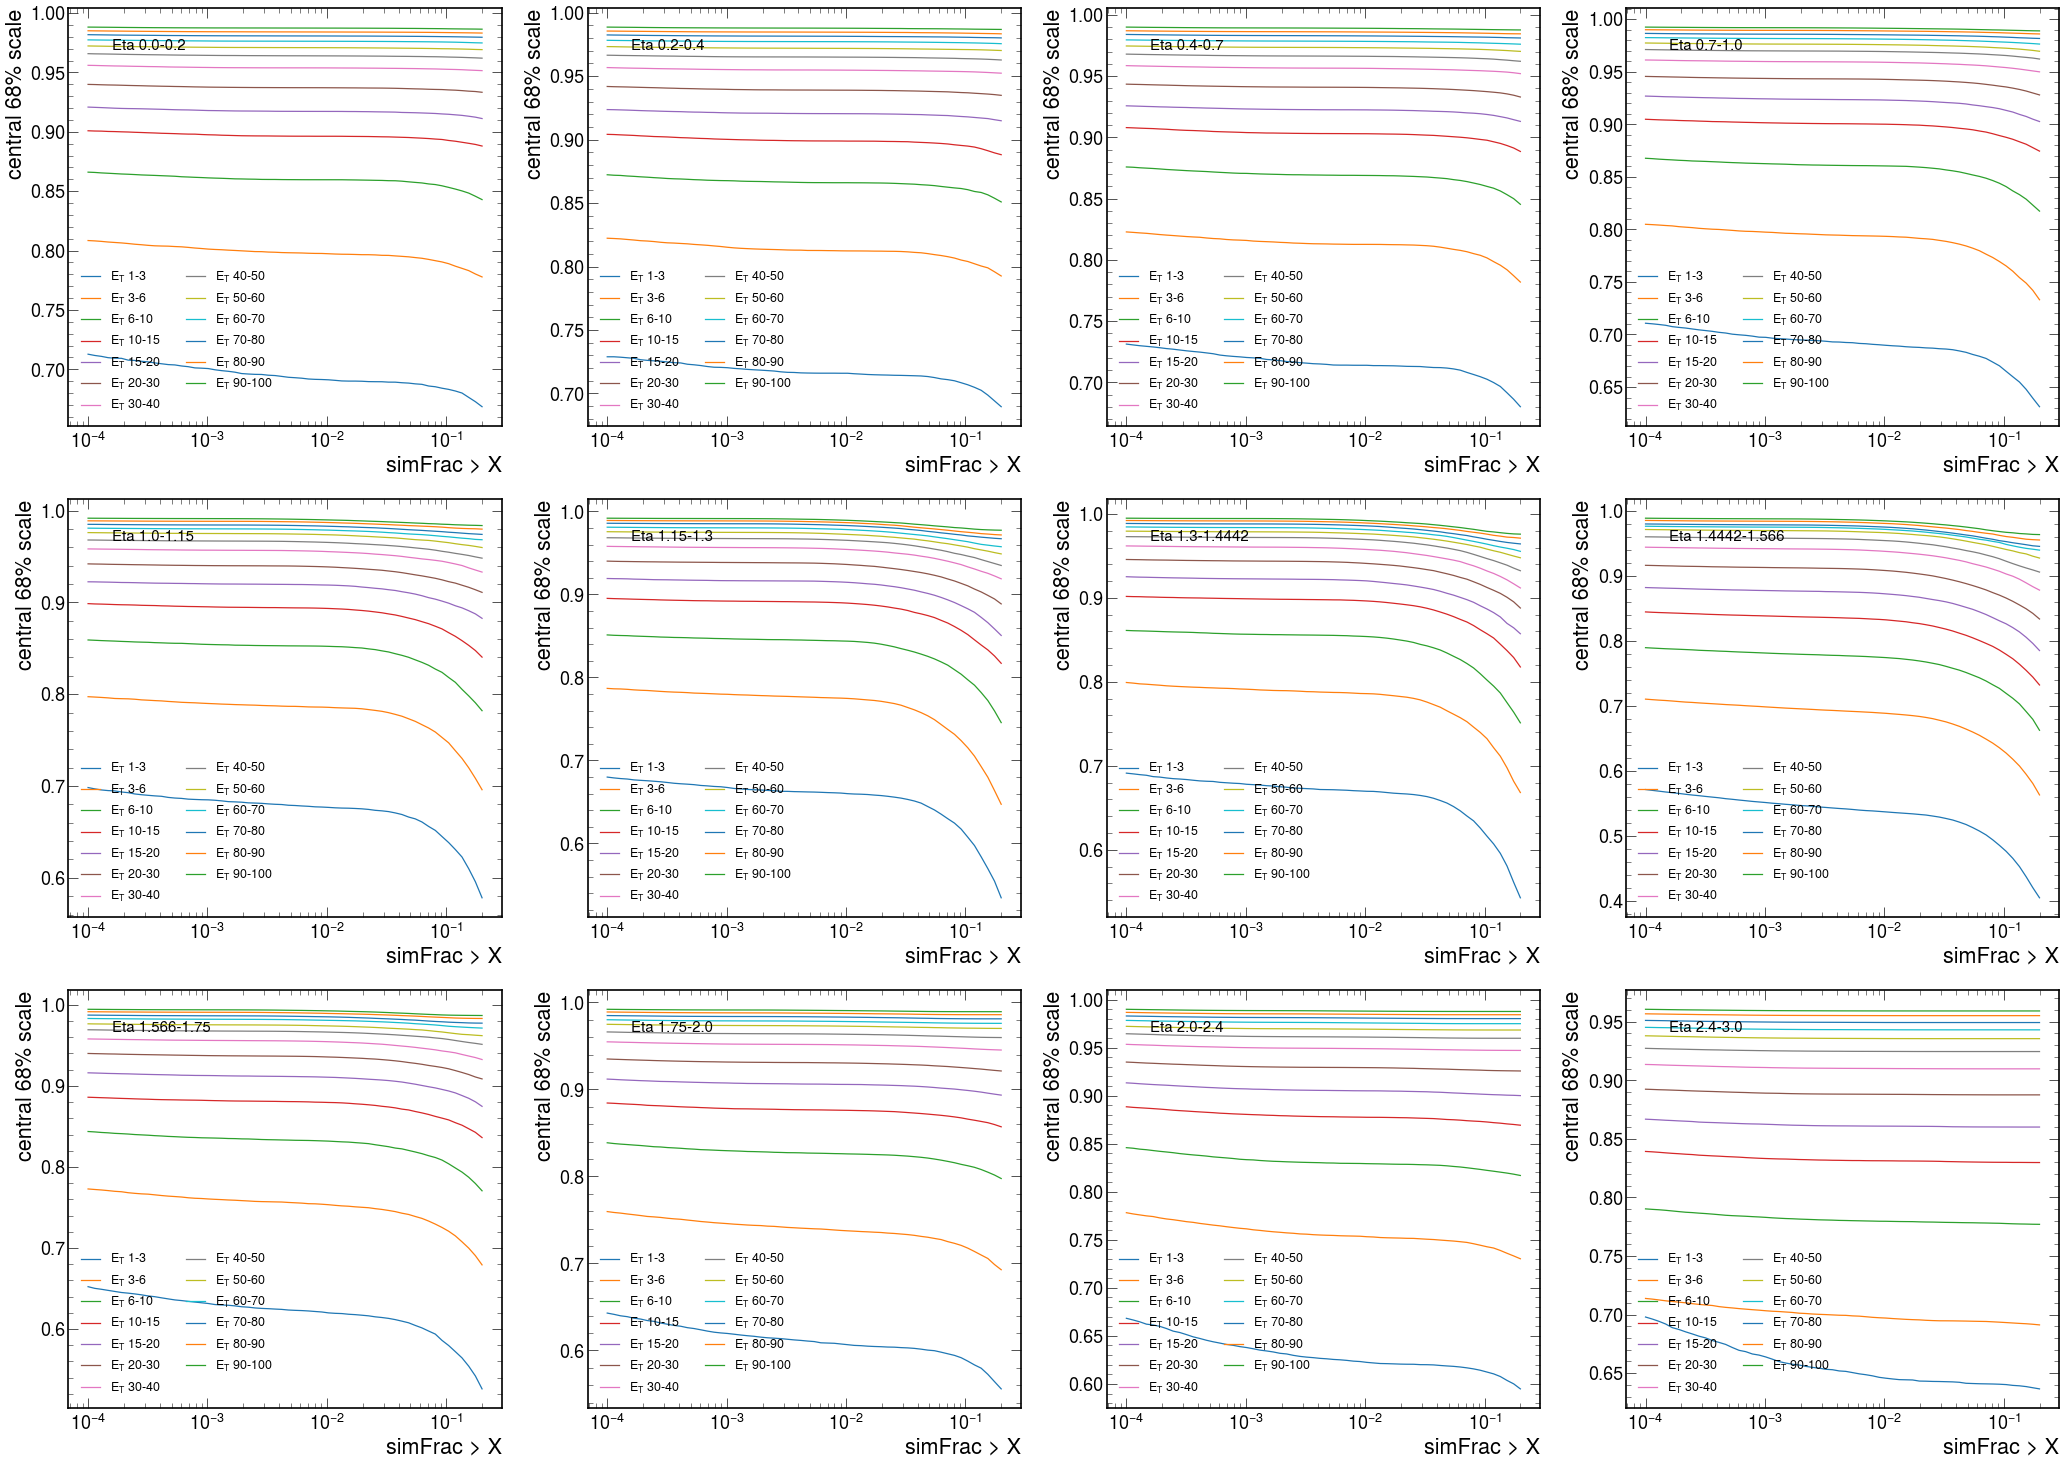

In [58]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

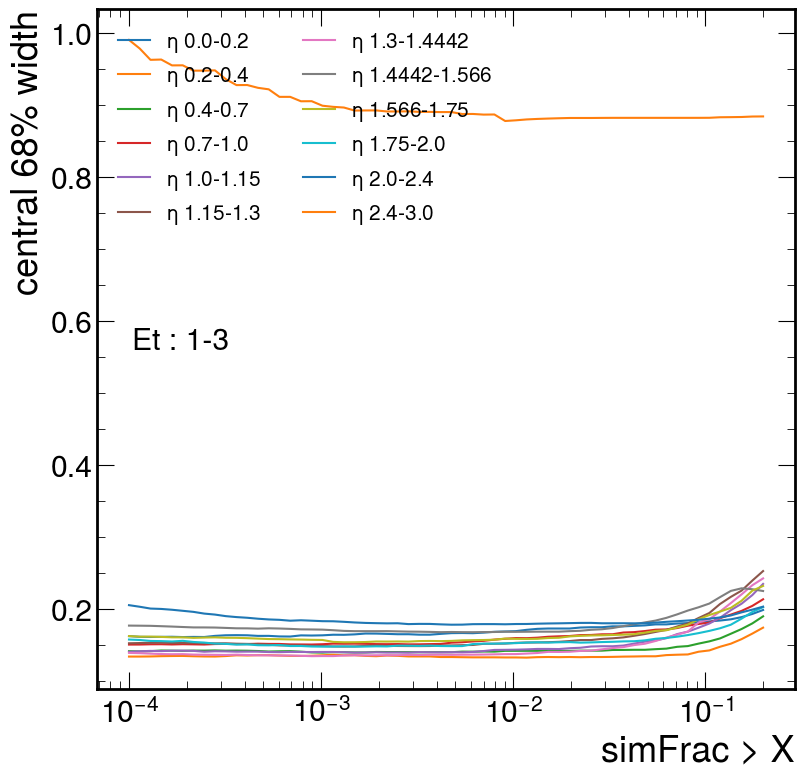

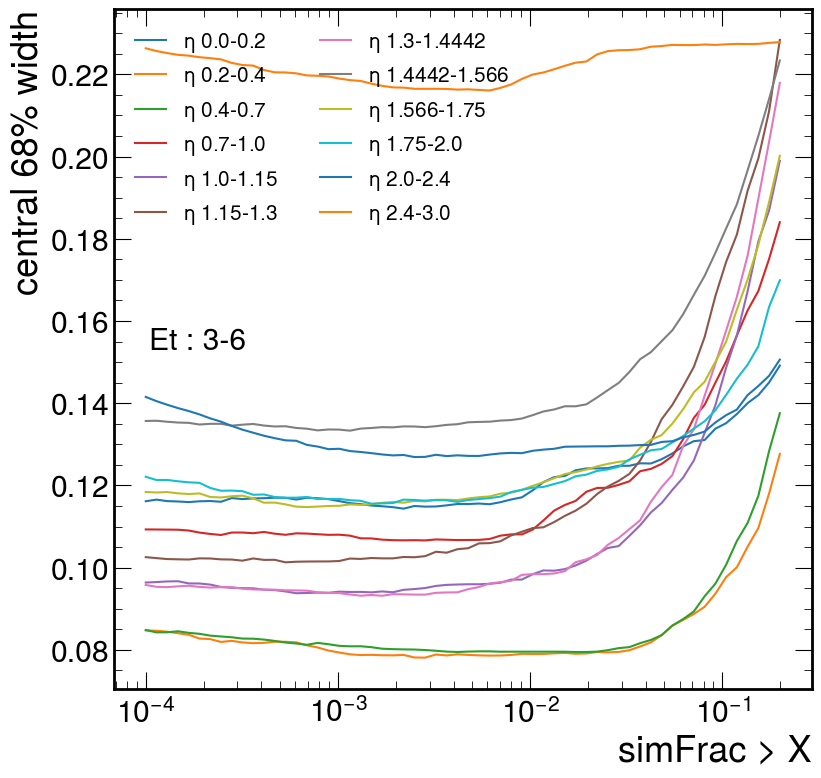

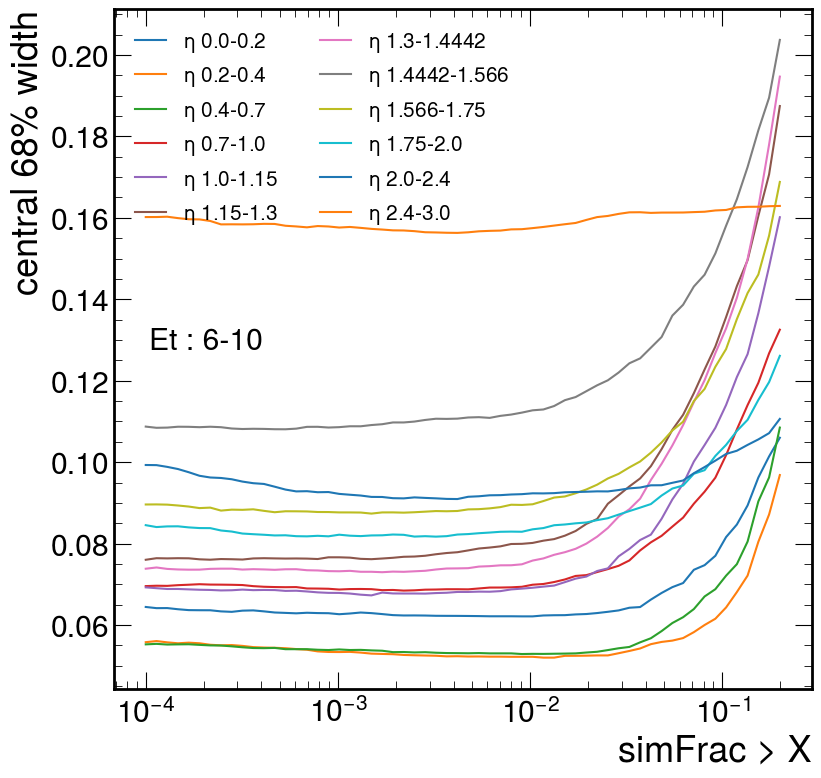

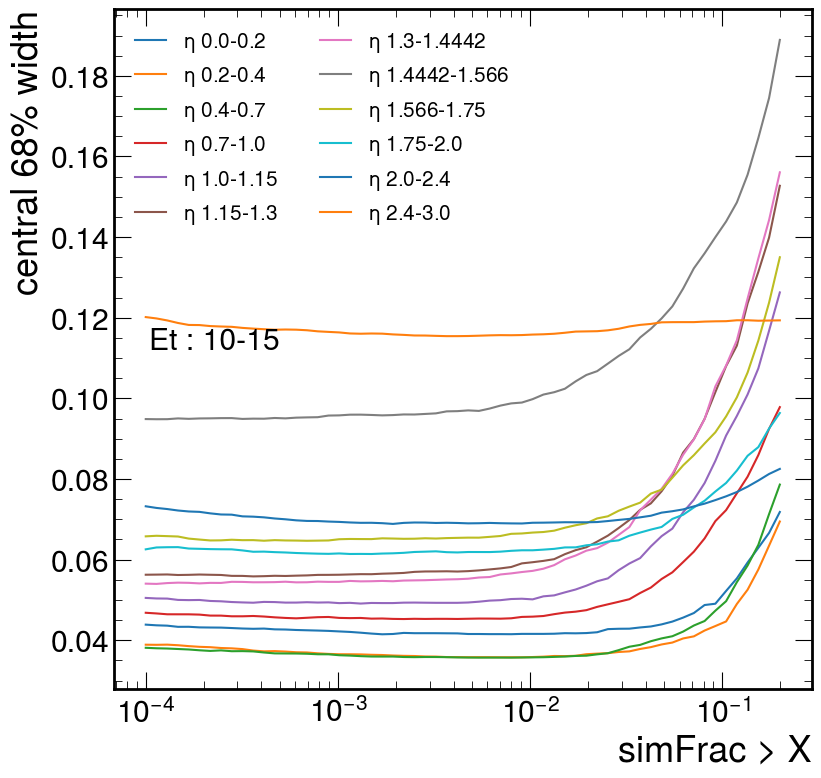

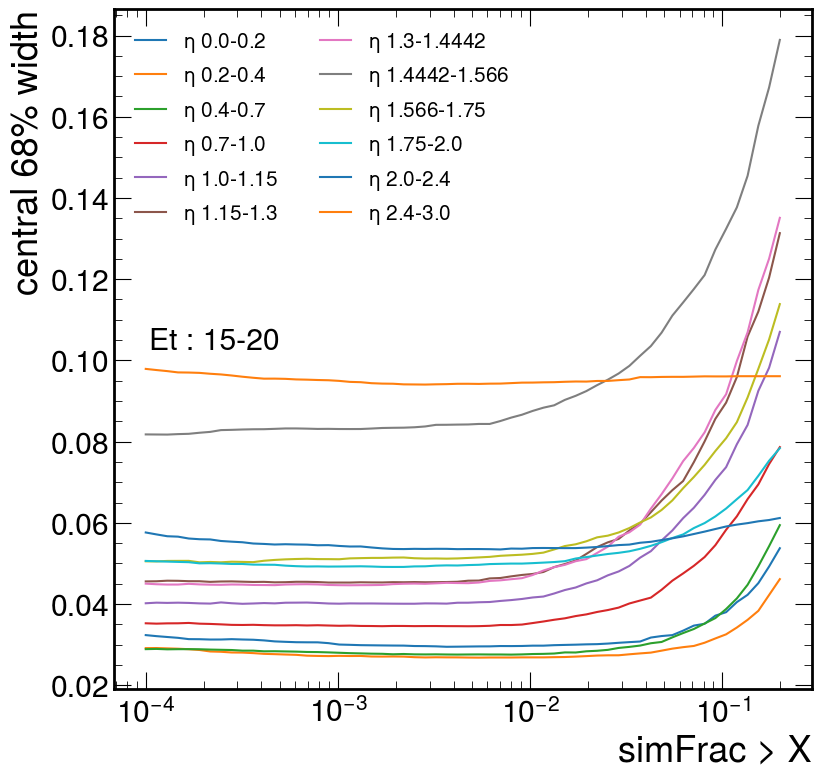

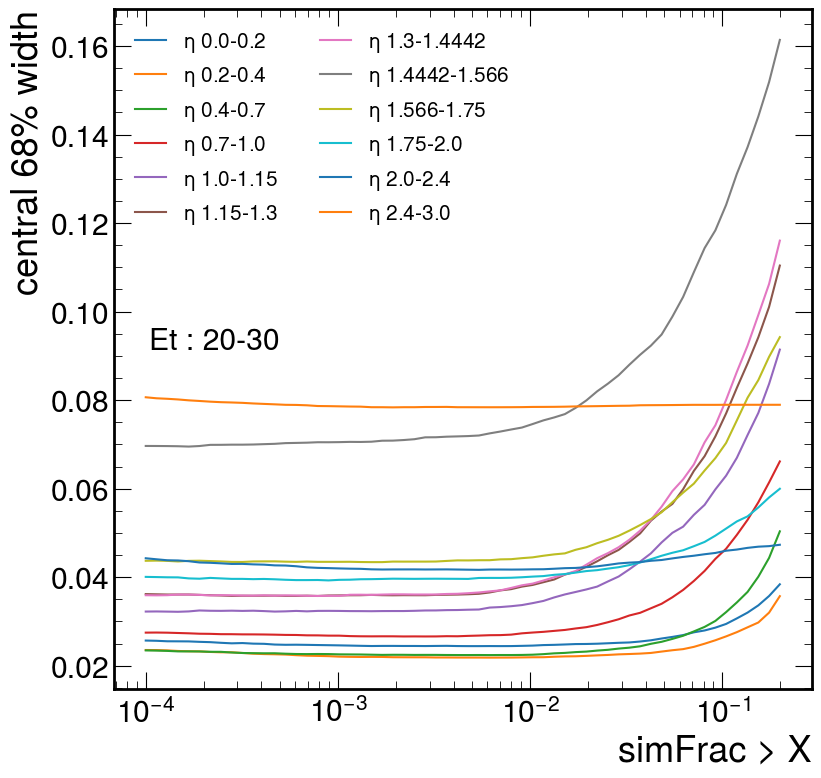

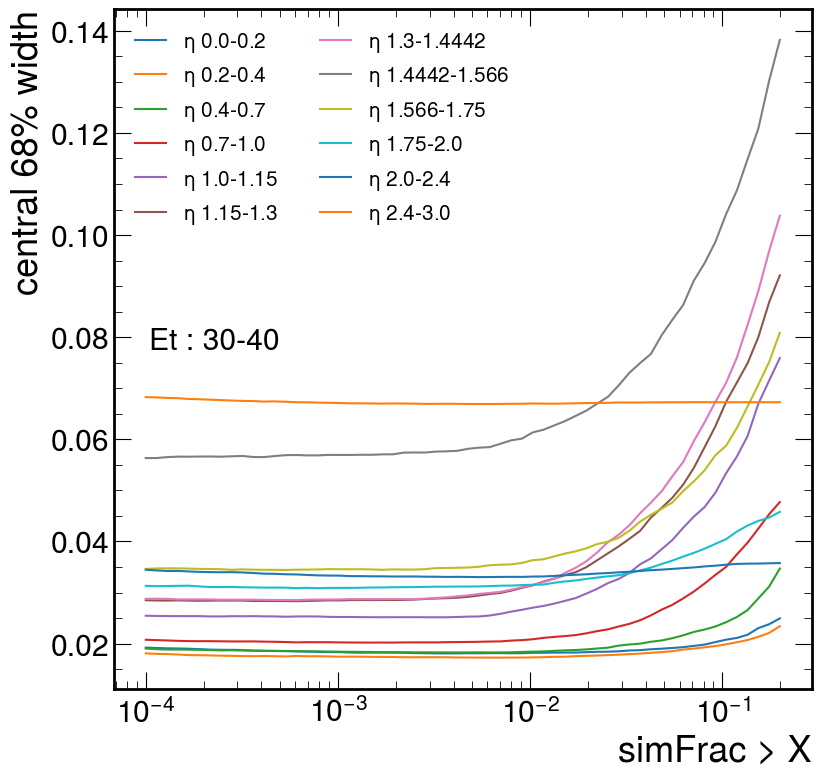

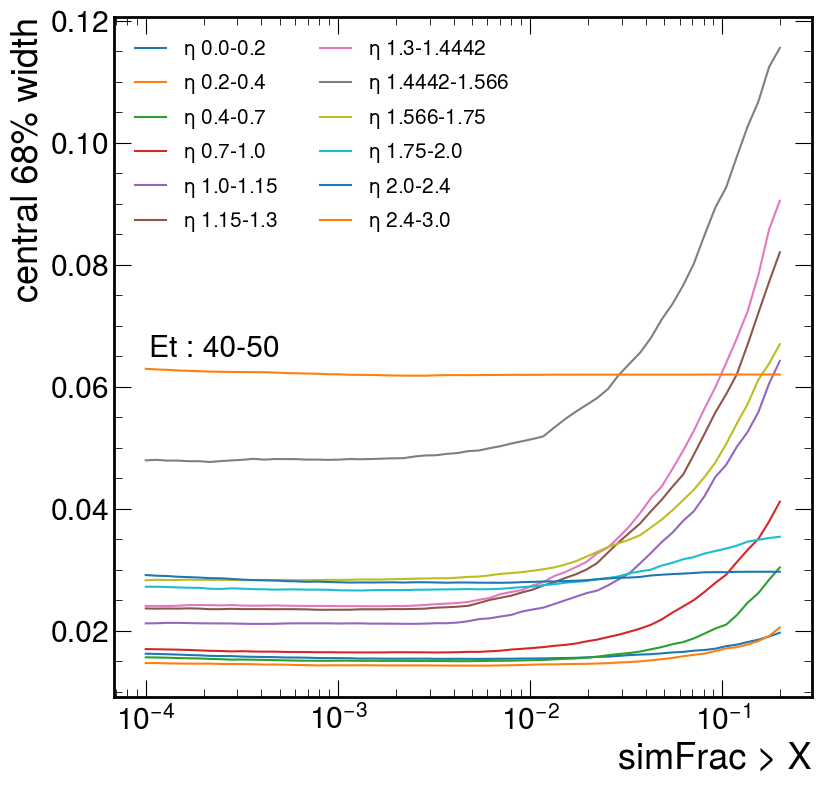

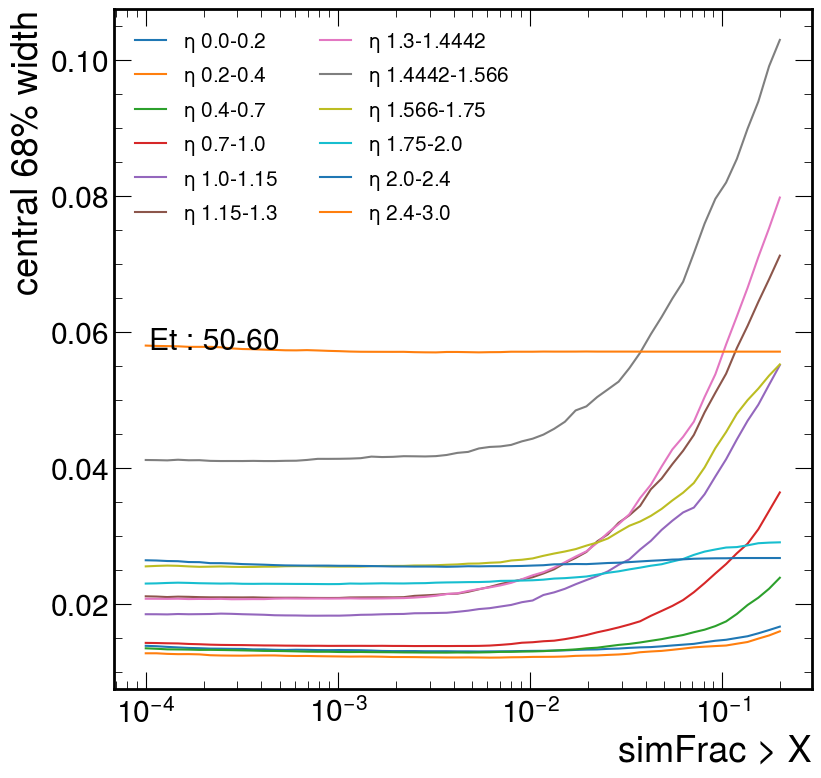

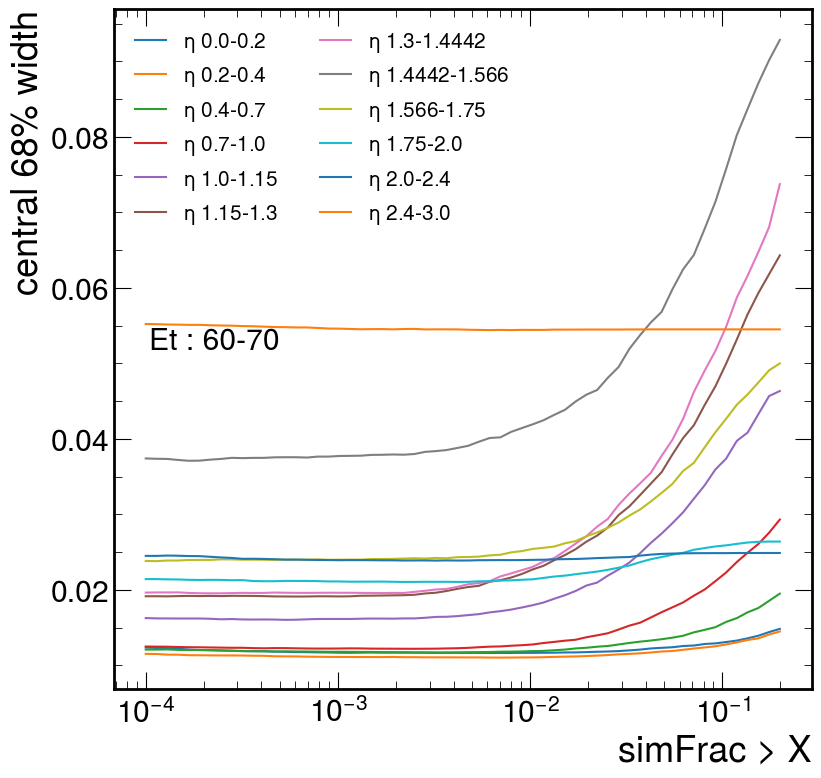

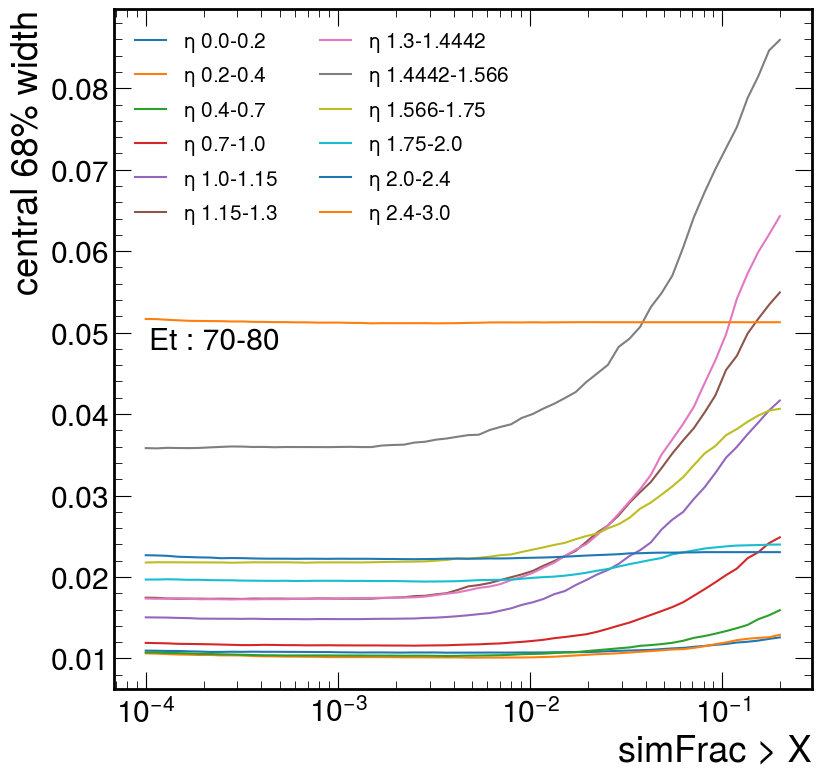

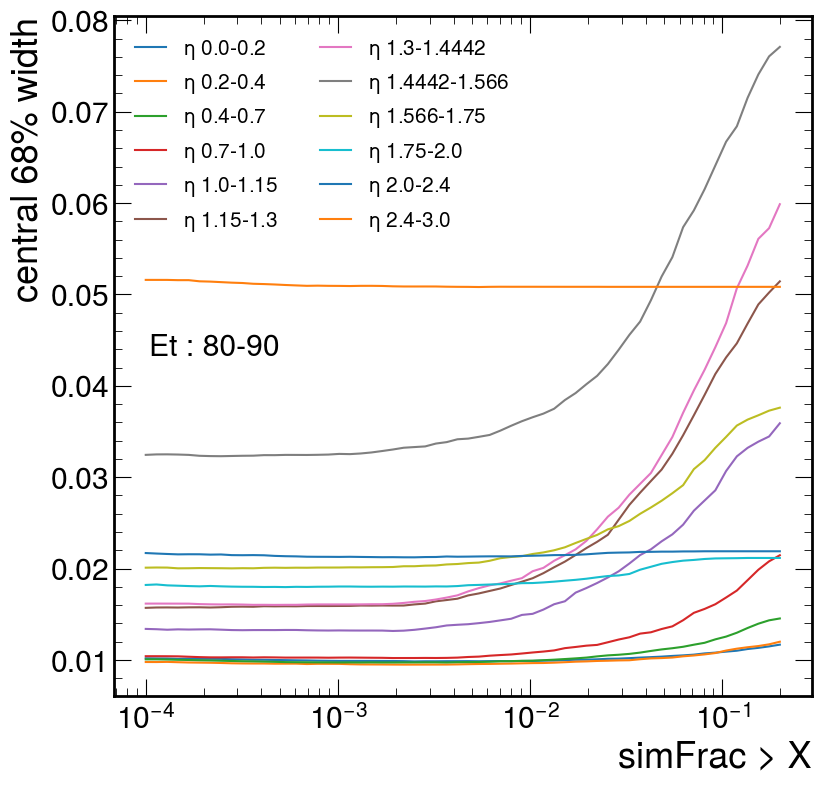

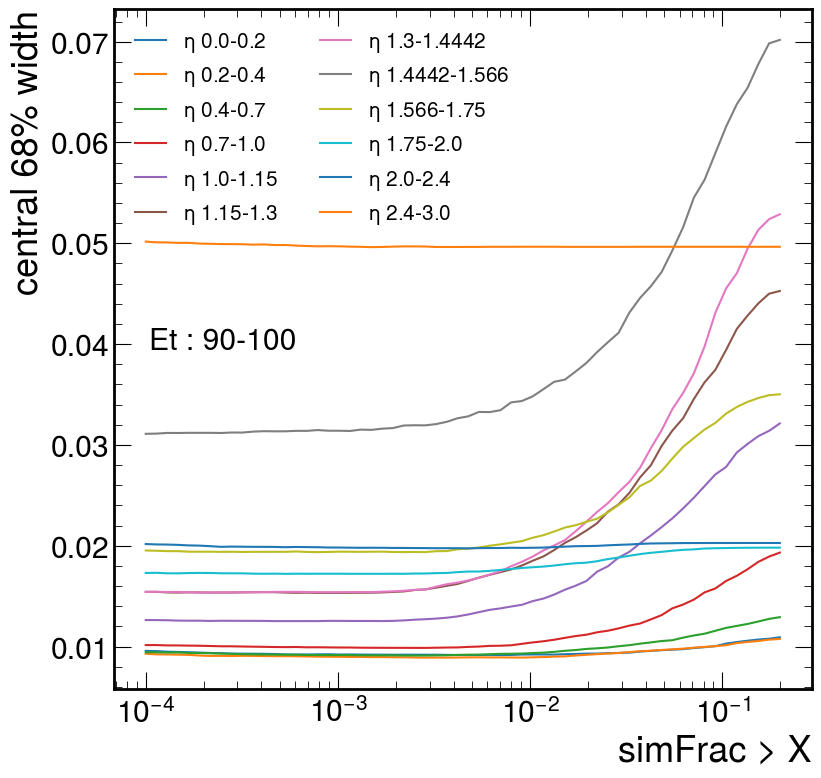

In [59]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

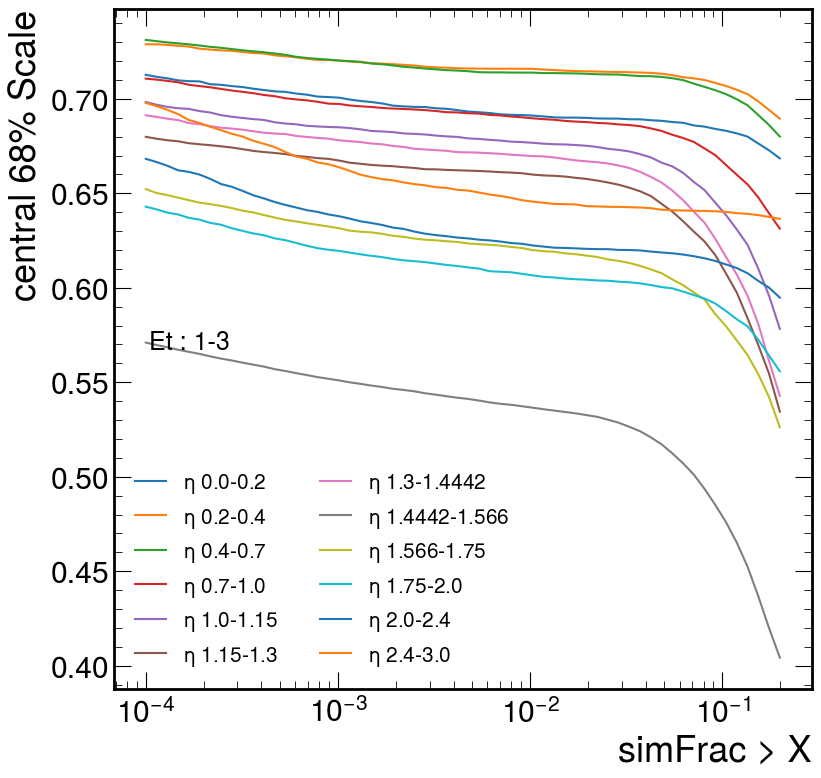

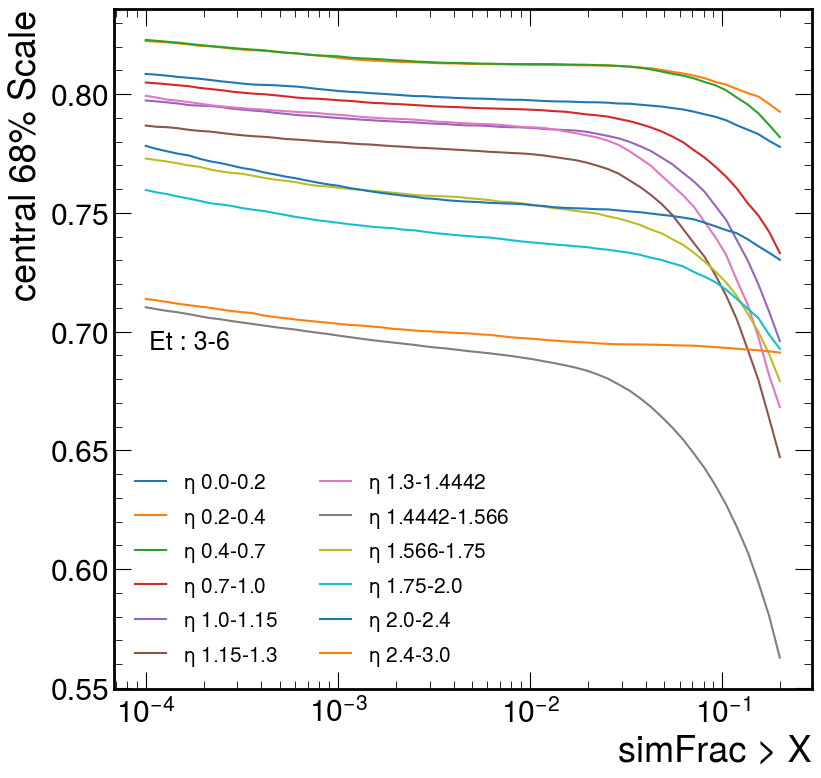

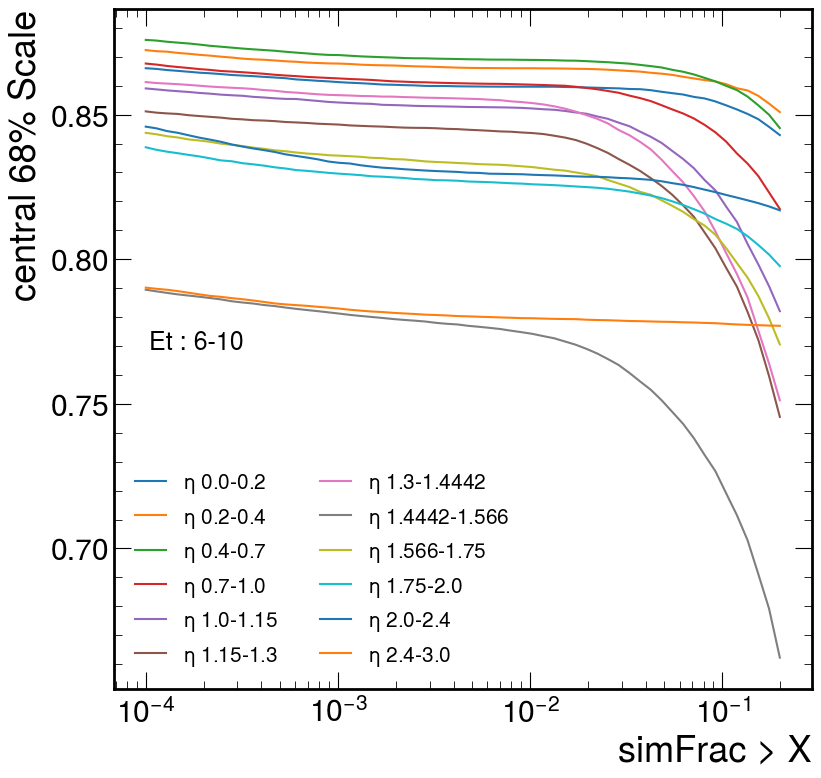

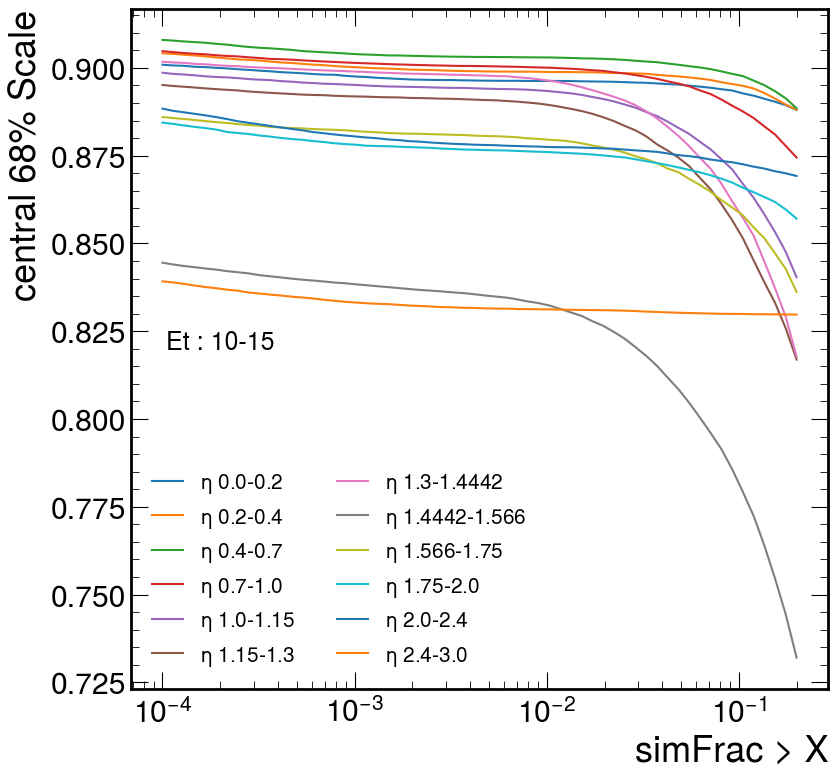

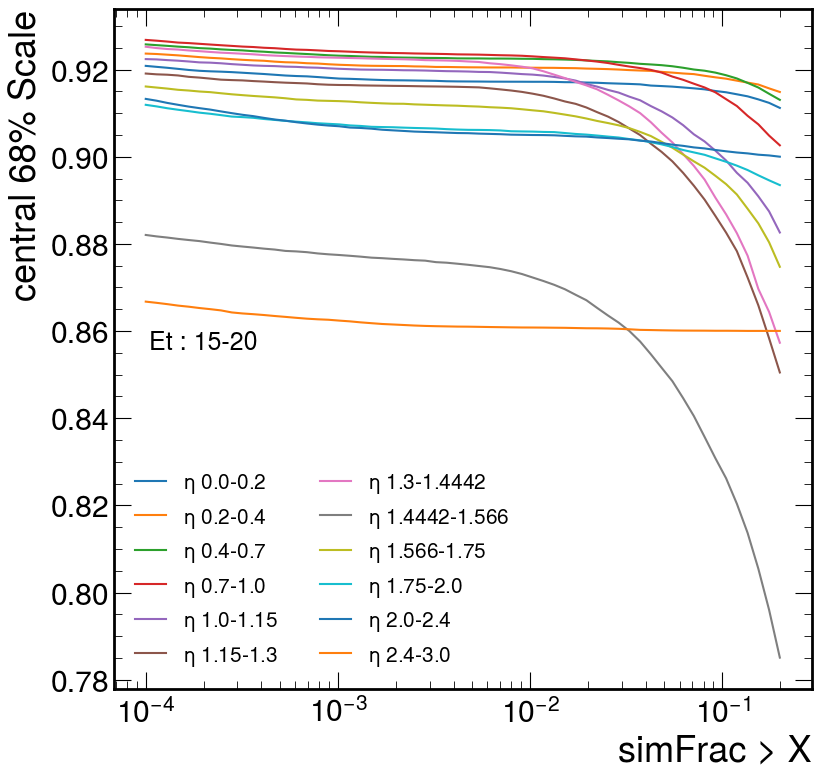

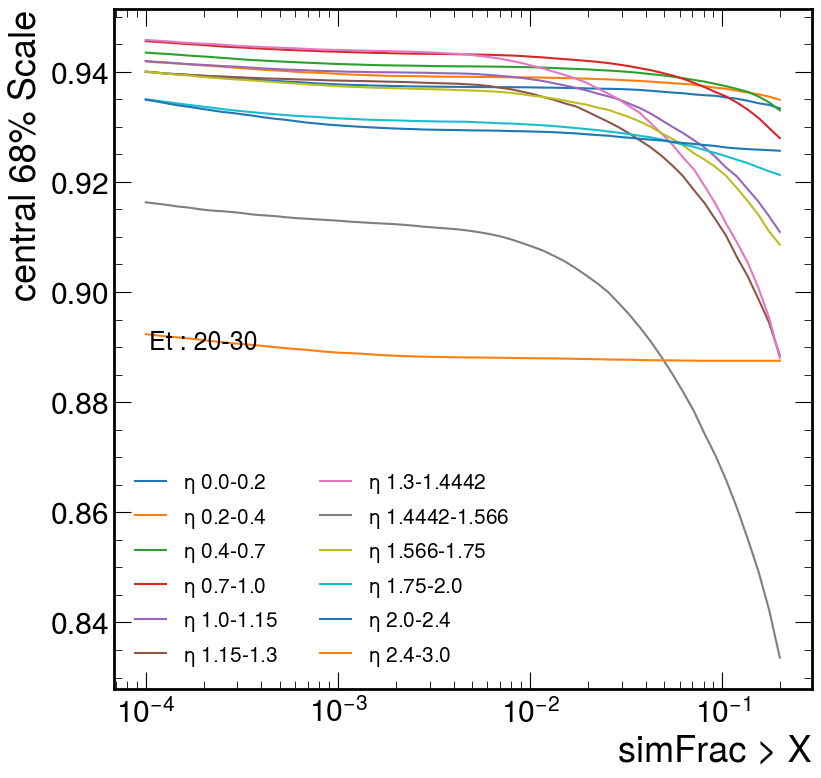

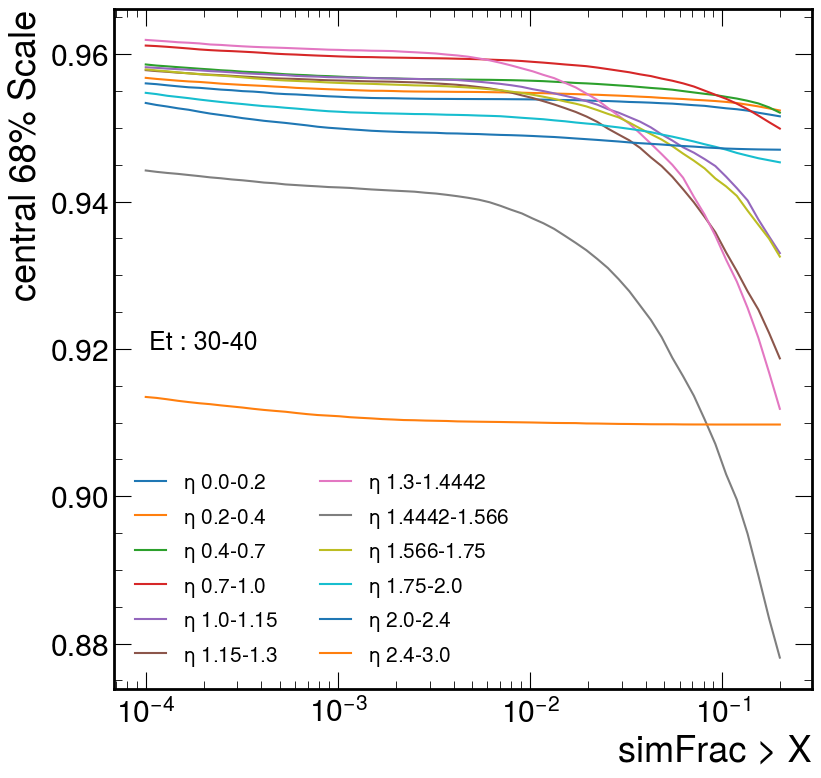

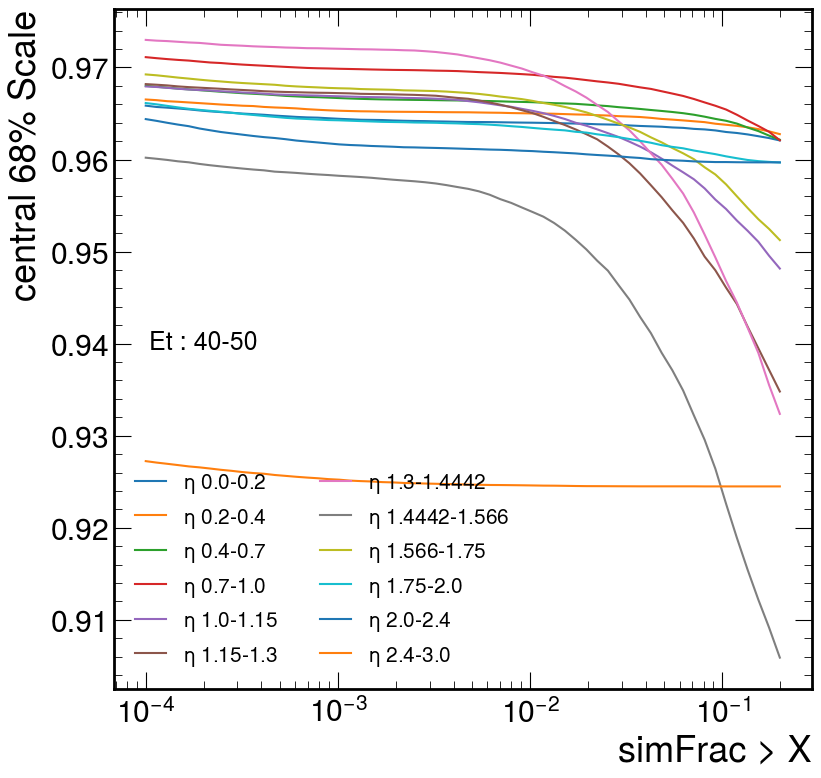

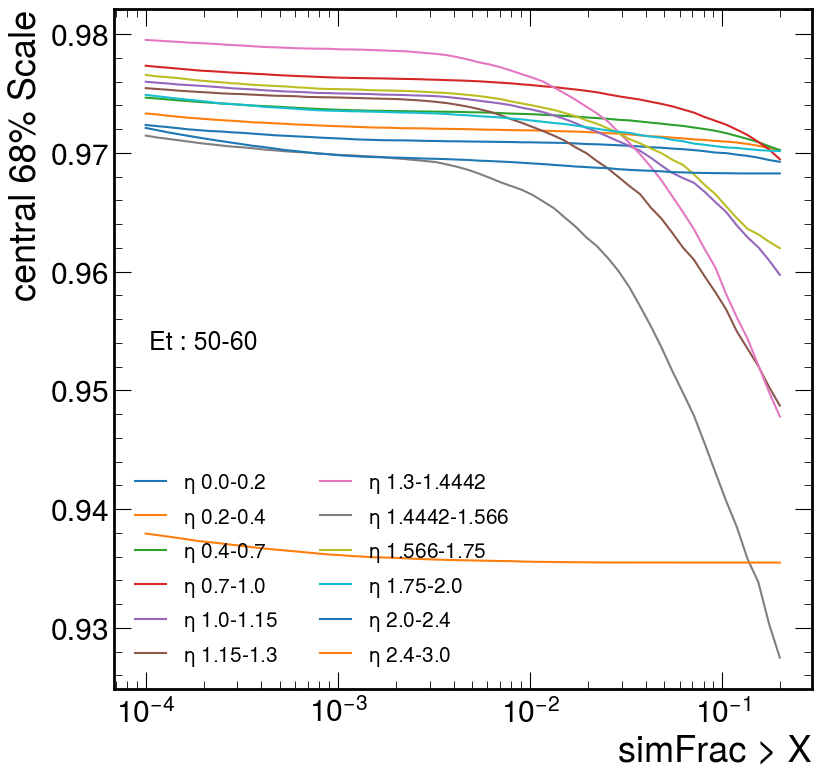

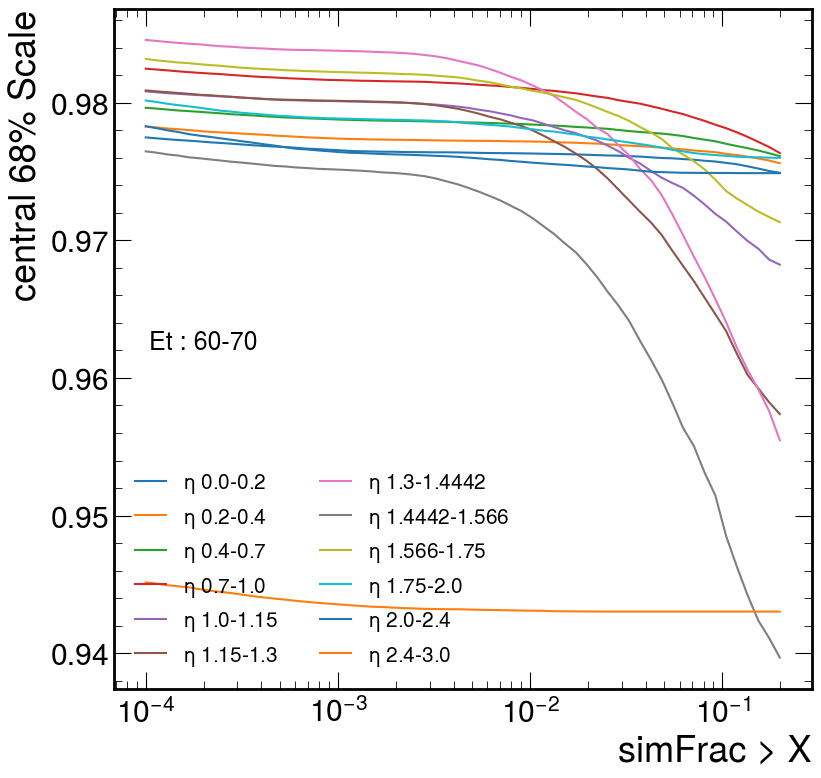

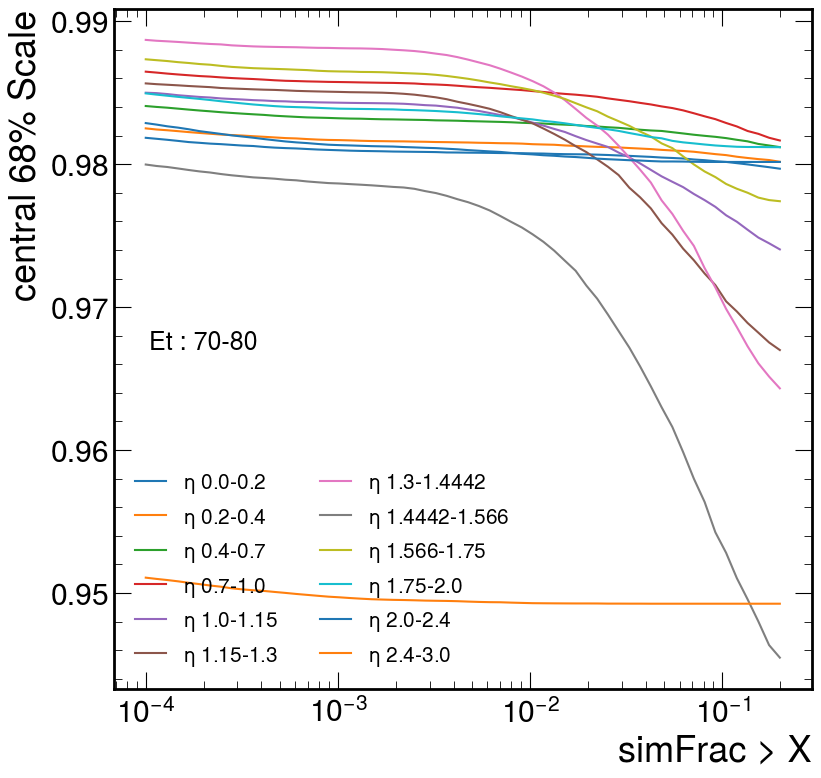

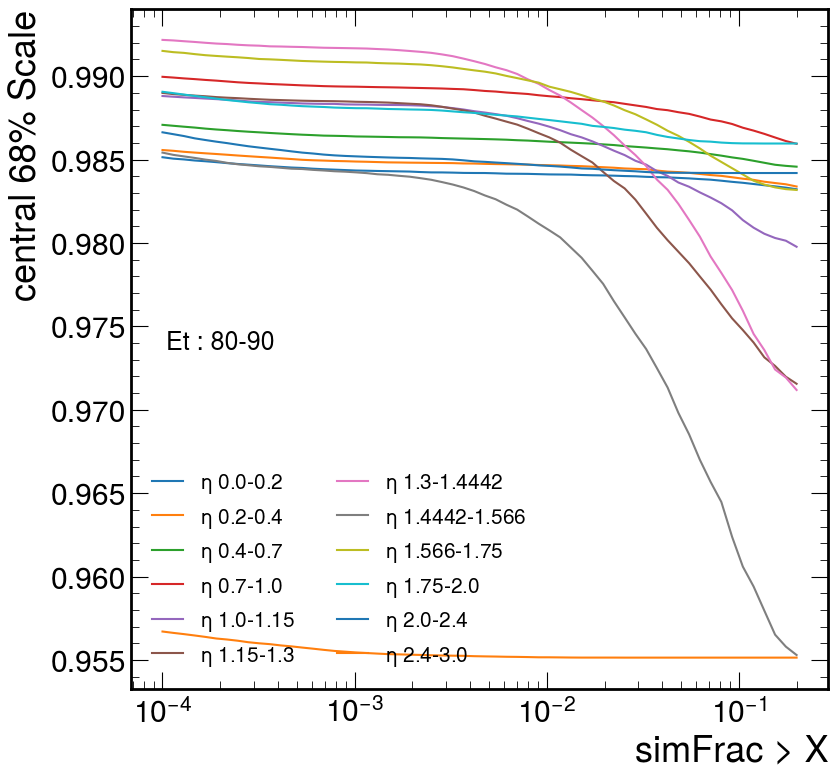

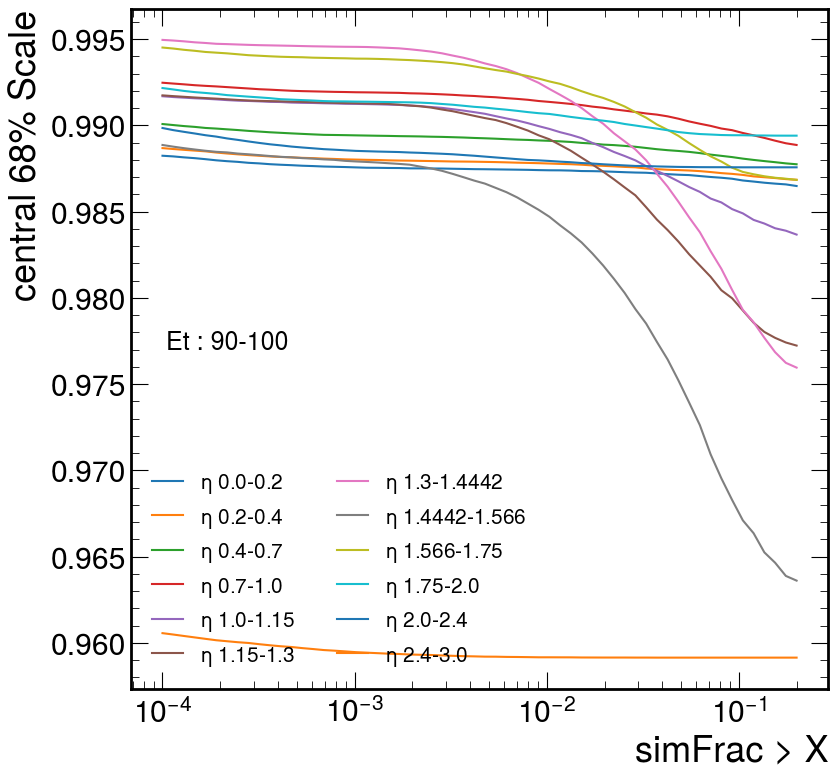

In [60]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary thresholds
Now we check which threshold corresponds to the best truth resolution in each eta/pt bin

In [22]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [23]:
simfrac_thr = a
simfrac_thr.to_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";", index=False)

In [24]:
#loading
simfrac_thr = pd.read_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";")

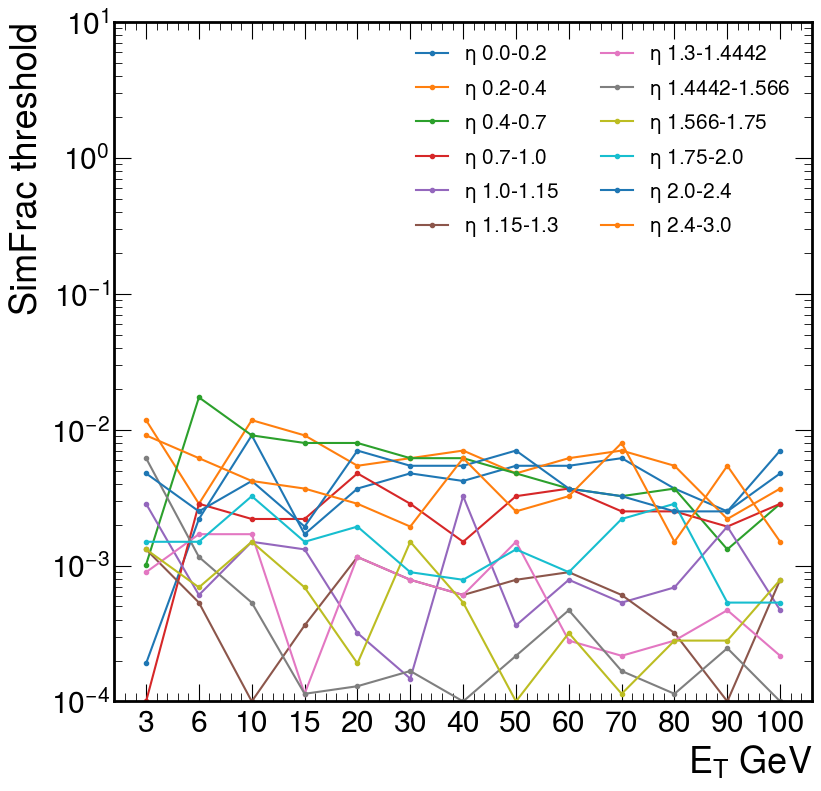

In [64]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker=".")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all_min.png')

ValueError: Passing a Normalize instance simultaneously with vmin/vmax is not supported.  Please pass vmin/vmax directly to the norm when creating it.

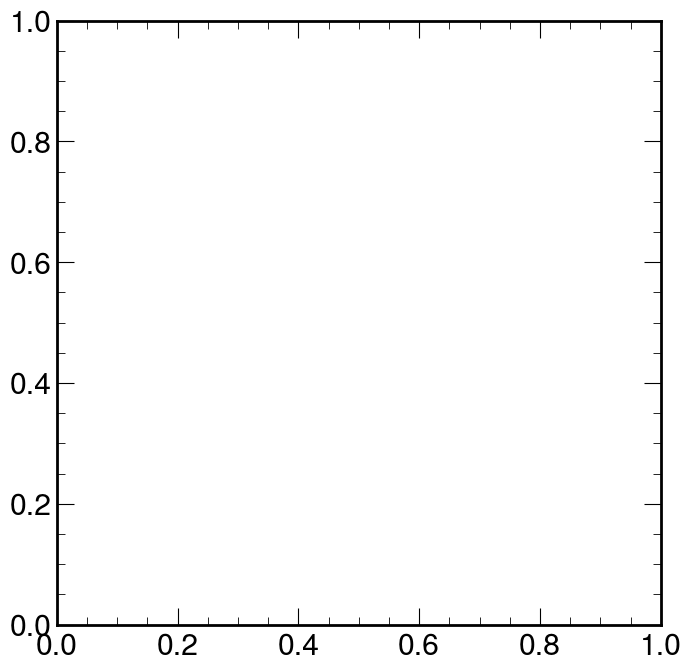

In [65]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=LogNorm(), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

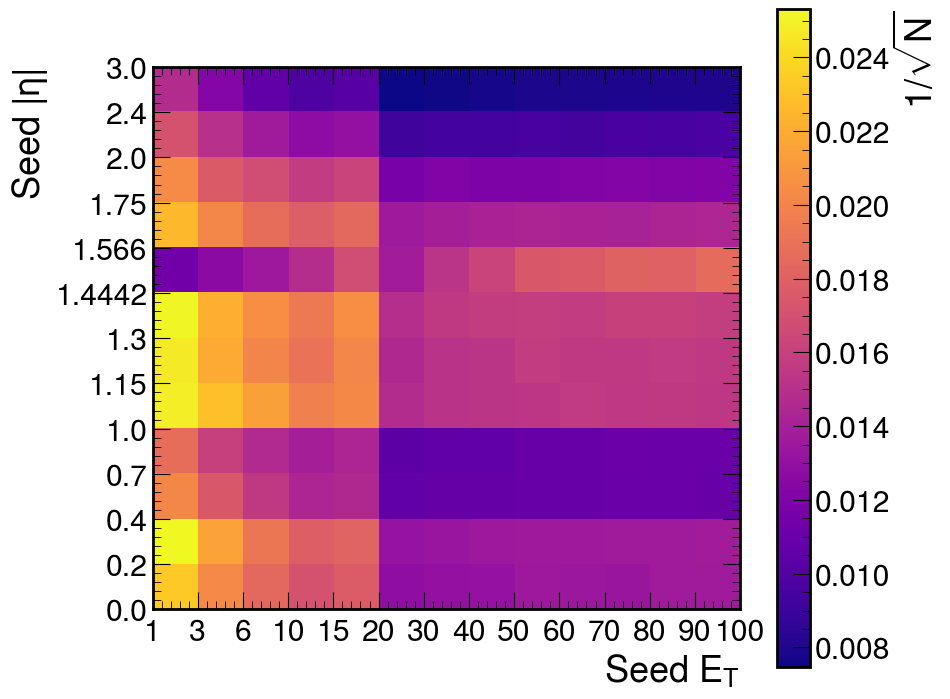

In [66]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

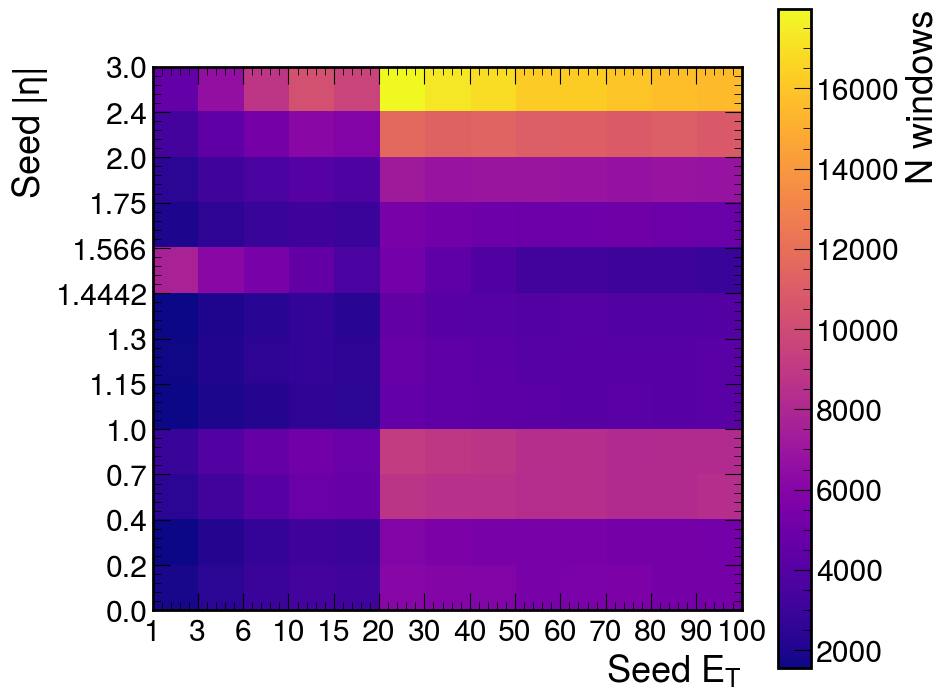

In [67]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

**Save thresholds to correctionlib**

In [25]:
import correctionlib, rich
import correctionlib.convert
import hist

In [26]:
simfrac_thr

eta_bin  et_bin       thr     scale     width   rel_err
0          0       0  0.001700  0.153117  0.153117  0.019440
1          1       0  0.009070  0.122968  0.122968  0.021096
2          2       0  0.001700  0.126803  0.126803  0.016688
3          3       0  0.000690  0.142785  0.142785  0.015352
4          4       0  0.001700  0.135823  0.135823  0.020847
..       ...     ...       ...       ...       ...       ...
139        7      11  0.000100  0.019202  0.019202  0.005261
140        8      11  0.000217  0.013586  0.013586  0.003344
141        9      11  0.000114  0.012550  0.012550  0.002872
142       10      11  0.003237  0.015603  0.015603  0.002276
143       11      11  0.009070  0.044653  0.044653  0.002051

[144 rows x 6 columns]

In [27]:
# 2D array with shapoe et_bin:eta_bin
frac_arr = simfrac_thr["thr"].values.reshape((len(ets)-1, len(etas)-1))
frac_arr.shape

(12, 12)

In [28]:
h_weight = hist.Hist(
            hist.axis.Variable(ets, name="seed_et"),
            hist.axis.Variable(etas, name="seed_eta"),
            storage="weight",
            data=np.concatenate([frac_arr[:,:,None], np.zeros(frac_arr.shape)[:,:,None]], axis=-1))
h_weight

Hist(
  Variable([1, 4, 10, 15, 25, 40, 50, 70, 100, 150, 200, 300, 500], name='seed_et'),
  Variable([0, 0.2, 0.4, 0.7, 1, 1.15, 1.3, 1.4442, 1.566, 1.75, 2, 2.4, 3], name='seed_eta'),
  storage=Weight()) # Sum: WeightedSum(value=0.457951, variance=0)

In [29]:
# Exporting it to correctionlib

# without a name, the resulting object will fail validation
h_weight.name = "simfraction_threshold_photon"
h_weight.label = "weight"
clibcorr = correctionlib.convert.from_histogram(h_weight)
clibcorr.description = "SimFractions thresholds for true matching in Photons"

# set overflow bins behavior (default is to raise an error when out of bounds)
#
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="SimFractions thresholds for true matching in Photons",
    corrections=[clibcorr],
)
rich.print(cset)

with open(f"{outputdir}/simfraction_thresholds_photons.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
SimFractions thresholds for true matching in Photons
📂
└── 📈 simfraction_threshold_photon (v0)
    SimFractions thresholds for true matching in Photons
    Node counts: MultiBinning: 1
    ╭────── ▶ input ──────╮ ╭───── ▶ input ─────╮
    │ seed_et (real)      │ │ seed_eta (real)   │
    │ seed_et             │ │ seed_eta          │
    │ Range: [1.0, 500.0) │ │ Range: [0.0, 3.0) │
    ╰─────────────────────╯ ╰───────────────────╯
    ╭─── ◀ output ───╮
    │ weight (real)  │
    │ No description │
    ╰────────────────╯

# Save histogram

Welcome to JupyROOT 6.30/04


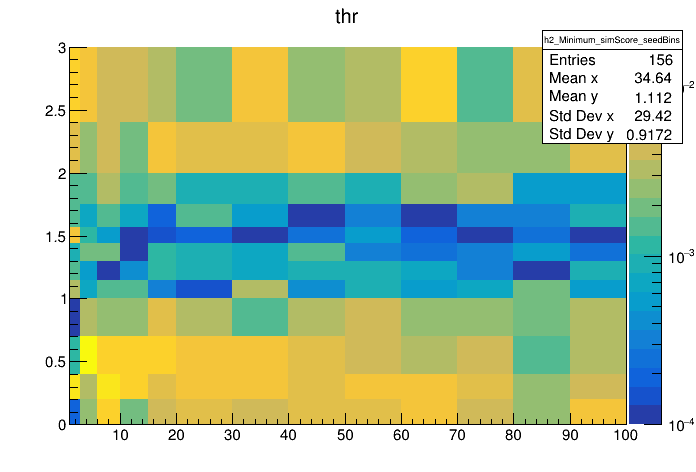

In [68]:
import ROOT as R
from array import array

h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)
    
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

out = R.TFile(outputdir+"/simScore.root","RECREATE")
h2.Write()
out.Close()

We loop on all the eta and et bins and apply the best threshold. Then we take the maximum dphi and deta from the seed to study the dimension of the window

# Window dimension after simFraction selection 
## Dimension by eta and Et

In [69]:
# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)
dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

/tmp/ipykernel_931/1387350978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_931/1387350978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))


In [70]:
results = []
for (iet, ieta), g in  dfb.groupby(["et_bin", "eta_bin"]):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)&(simfrac_thr.et_bin == iet)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": 'max' ,
                         "deta_seed": "max", 
                    })
    A["ieta"] = ieta
    A["iet"] = iet
    results.append(A)
    
WS = pd.concat(results)

Text(1, 0, 'Max $\\Delta\\phi(cl-seed)$')

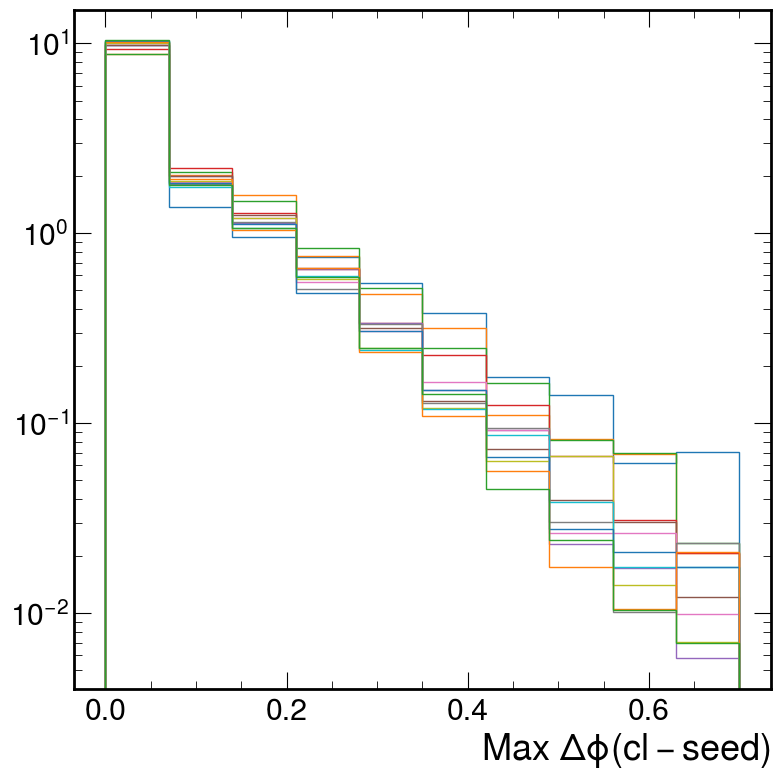

In [71]:
nEt = len(ets)-1
nEta = len(etas)-1
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].dphi_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.7), bins=10, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\phi(cl-seed)$")
#ax.legend()

Text(1, 0, 'Max $\\Delta\\eta(cl-seed)$')

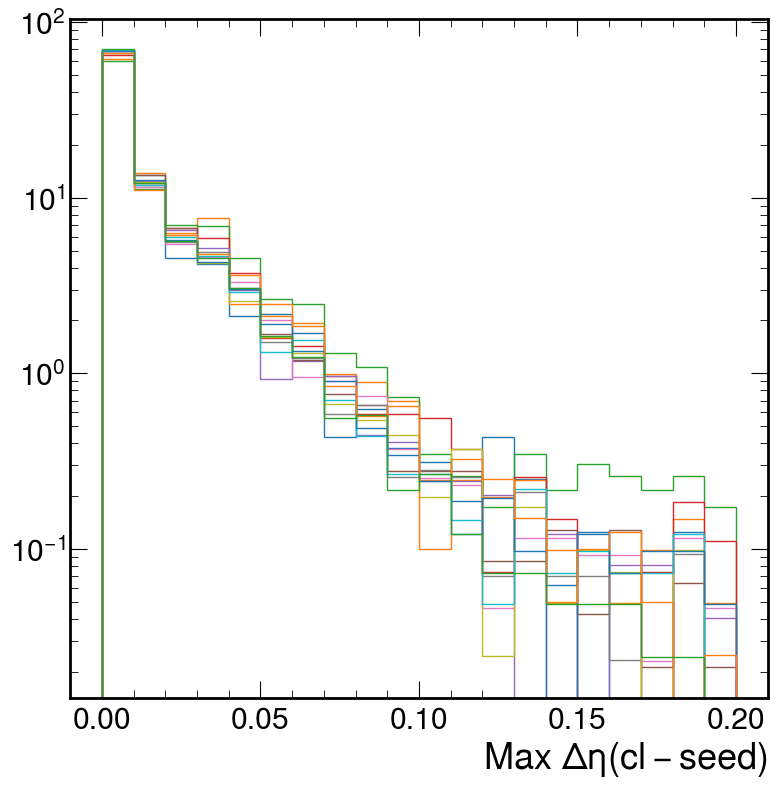

In [72]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].deta_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.2), bins=20, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\eta(cl-seed)$")
#ax.legend()

## Only by seed Eta

In [73]:
results = []
for ieta, g in  dfb.groupby("eta_bin"):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": [np.min, np.max],
                         "deta_seed":  [np.min, np.max]
                    })
    A["ieta"] = ieta
    results.append(A)
    
WS_etaonly = pd.concat(results)

In [74]:
WS_etaonly.dphi_seed.amin

window_index
aufwdtyh    0.000000
mdykzvvm    0.000000
hoatiipd    0.000000
enktxpnf   -0.020133
aykwjwsg    0.000000
              ...   
iagcqymq    0.000000
ooifpurz    0.000000
hzmbjrwp    0.000000
xrhdcfsk    0.000000
myghjgkq    0.000000
Name: amin, Length: 3900748, dtype: float64

In [75]:
maxq = 0.995
maxWS_eo = WS_etaonly.groupby('ieta').apply(lambda df: pd.Series(
    {"dphi_min": df.dphi_seed.amin.quantile(1-maxq),
     "dphi_max": df.dphi_seed.amax.quantile(maxq),
     "deta_min": df.deta_seed.amin.quantile(1-maxq),
     "deta_max": df.deta_seed.amax.quantile(maxq)}))

maxWS_eo.reset_index(level=0, inplace=True)
maxWS_eo.reset_index(level=0, inplace=True)

Text(0, 1, '$\\Delta\\phi$')

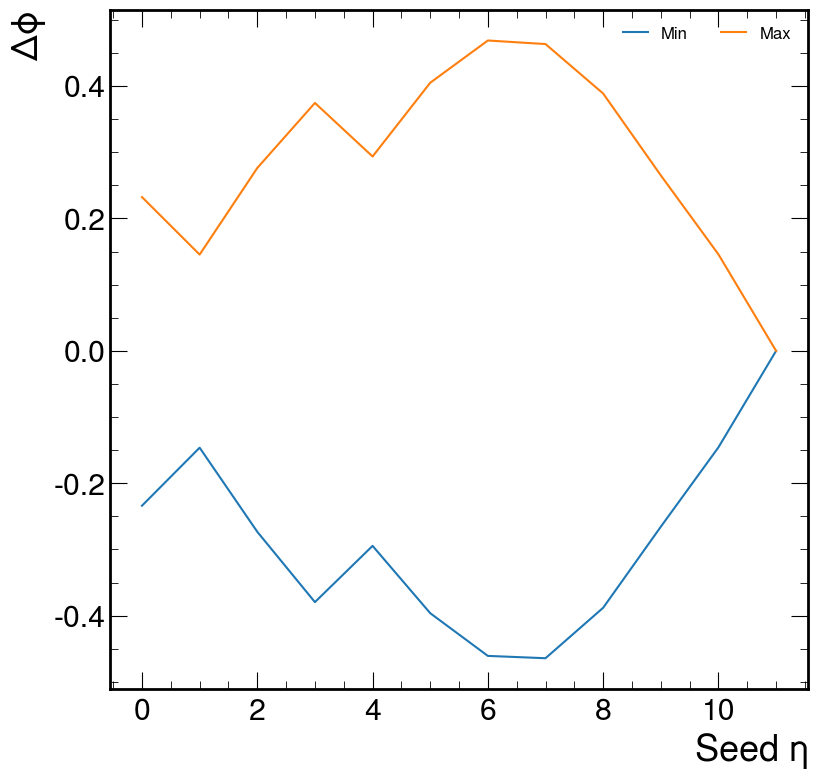

In [76]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")

Text(0, 1, '$\\Delta\\eta$')

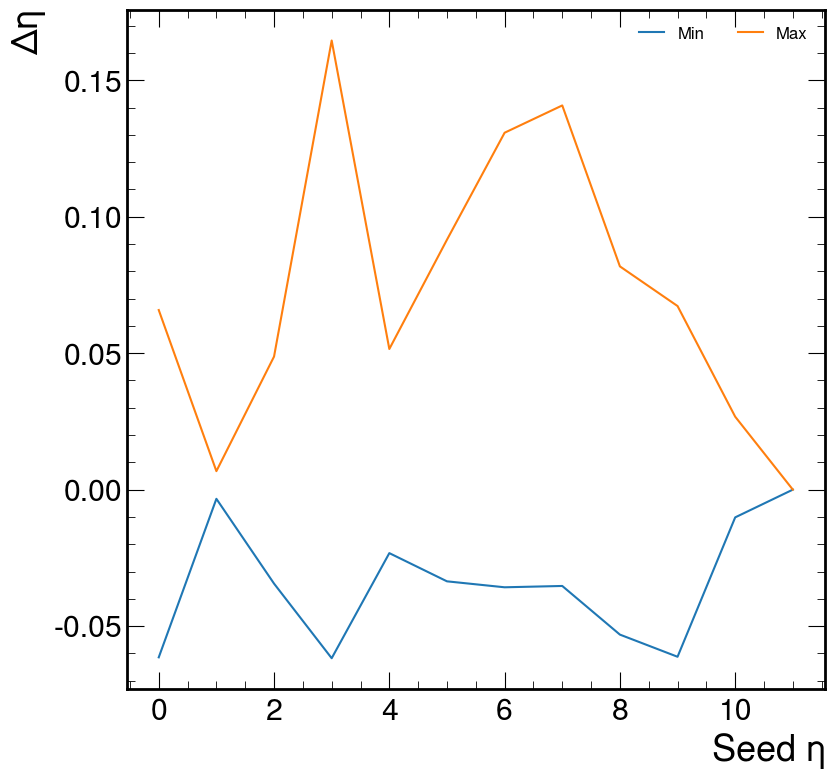

In [77]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(maxWS_eo.ieta, maxWS_eo.deta_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.deta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")